# Welcome

## Package loading



In [93]:
from __future__ import print_function
import sys
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
import matplotlib as plt
import numpy as np
import pandas as pd
import json
import pprint
from request_openfda import *
from pandas.io.json import json_normalize
import yaml
import urllib.request
import warnings
warnings.filterwarnings("ignore")


pp = pprint.PrettyPrinter(indent=4)
sns.set_context(context='talk')

pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# raise StopExecution

## Essential files preparation 

1. Get the searchable fields 

```console
https://open.fda.gov/apis/drug/event/searchable-fields
```

In [89]:

url="https://open.fda.gov/fields/drugevent.yaml"
    
file_name = r"./drugs_fields.yaml"
try:
    if os.path.getsize(file_name) > 0:
        # Non empty file exists
        pass
    else:
        # Empty file exists
        urllib.request.urlretrieve(url, file_name)
except OSError as e:
    urllib.request.urlretrieve(url, file_name)

with open(file_name) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    attr_list = yaml.load(file, Loader=yaml.FullLoader)

searchable_fields = []
get_searchable_fields(searchable_fields, attr_list)
print("Num fields: ", len(searchable_fields))
#pp.pprint(searchable_fields)


Num fields:  86


2. Get the country codes [NOTE: certain countries whose sovereignty is another country, such as Åland Islands (AX) is part of Finland (FI)]

In [90]:
url="https://datahub.io/core/country-list/r/data.csv"
file_name = r"country_codes.csv"
try:
    if os.path.getsize(file_name) > 0:
        # Non empty file exists
        pass
    else:
        # Empty file exists
        urllib.request.urlretrieve(url, file_name)
except OSError as e:
    urllib.request.urlretrieve(url, file_name)
   
df_country_code = pd.read_csv(file_name)
print("ISO 3166-1 standard currently comprises %i countries " % df_country_code.shape[0])
#df_country_code.head()

ISO 3166-1 standard currently comprises 249 countries 


The kinds of questions of interest:

 Are different adverse events reported in different countries? 

 What are the different adverse events associated with different disease areas? 

 What drugs tend to be taken together?

In [35]:
# Try to download data files
import requests
from urllib.parse import urlparse

#download_data_files()

## Countries of adverse events?

Based on the analysis in "stage_1", we learned that
the information about who reports are available in one of the three fields
    
    primarysourcecountry only use country code, e.g. UK; 
    
    primarysource.reportercountry can use either country code or full name (e.g. ) 
    
    NOTE: primarysourcecountry is not available in FDA website interactive tool
    https://open.fda.gov/apis/drug/event/explore-the-api-with-an-interactive-chart/ [who reports]
   
 DEFINITION: 
   
 ```console
    primarysource.reportercountry:
        Country from which the report was submitted
    primarysourcecountry
        Country of the reporter of the event
    occurcountry 
        The name of the country where the event occurred.
 ```
        
    Its meaning can be different from "occurcountry"?
    
    A report through a company when "_exists_:companynumb" 
    
    A report by public when "_missing_:companynumb"
    
    
Query with "20040101+TO+20191201" using one of the three fields below confirms that there are inconsistency in data among the three fields. 


In [36]:
occurcountry_df = pd.read_pickle("./images/occurcountry.pkl")
primarysourcecountry_df = pd.read_pickle("./images/primarysourcecountry.pkl")
primarysource_reportercountry_df = pd.read_pickle("./images/primarysource.reportercountry.pkl")
# display(occurcountry_df)
# display(primarysourcecountry_df)
# display(primarysource_reportercountry_df)
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
occurcountry_df.columns
display_side_by_side(occurcountry_df.sort_values(by=["term"]), primarysourcecountry_df.sort_values(by=["term"]), primarysource_reportercountry_df.sort_values(by=["term"]))


,term,count
62,AE,1219
16,AR,23759
28,AT,14005
9,AU,60246
99,BA,232
69,BD,995
18,BE,19667
55,BG,2493
7,BR,87636
76,BW,700


In [37]:
from IPython.display import Image
from IPython.core.display import HTML 
print("occurcountry")
x1 = Image(url= "./images/occurcountry.png")
print("primarysourcecountry")
x2 = Image(url= "./images/primarysourcecountry.png")
print("primarysource.reportercountry")
x3 = Image(url= "./images/primarysource.reportercountry.png")
display(x1, x2, x3)

occurcountry
primarysourcecountry
primarysource.reportercountry


To understand what field to be used, I check the file content of the oldest and the latest json.zip files which showed that 

* "primarysource.reportercountry" are always available. However, the content of 'primarysource.reportercountry' are inconsistent, and many fields are marked with "COUNTRY NOT SPECIFIED". 

* only records in newer files have "occurcountry". 

Studying recent data is better fit with using "occurcountry", e.g.
```console
total recs having 'primarysourcecountry'  11734
total recs having 'occurcountry'  11999
```

**Maybe, we can use 'occurcountry' as the criteria column for newer data; and use "primarysource.reportercountry" in older data?**

In [38]:
# Here, it shows the presence of these three fields in older data and newer data

import zipfile  
from collections import OrderedDict

test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
# test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
with zipfile.ZipFile(test_file, "r") as z:
   for filename in z.namelist():  
      print("File: ", test_file)
      with z.open(filename) as f:  
         data = f.read()  
         # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
         json_data = json.loads(data.decode("utf-8"))
        
# pp.pprint(json_data)

all_records = json_data["results"]

count_primarysource = 0
count_primarysourcecountry = 0
count_occurcountry = 0
for rec in all_records:
    if "primarysource" in rec.keys():
        count_primarysource += 1
    if "primarysourcecountry" in rec.keys():
        count_primarysourcecountry += 1
    if "occurcountry" in rec.keys():
        count_occurcountry += 1
print("total recs having 'primarysource.reportercountry' ", count_primarysource)
print("total recs having 'primarysourcecountry' ", count_primarysourcecountry)
print("total recs having 'occurcountry' ", count_occurcountry)

#### ==================================
#### ==================================

# test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
# test_file = "./data/2011 Q1 (part 1 of 11)/drug-event-0001-of-0011.json.zip"
test_file = "./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip"
# test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
with zipfile.ZipFile(test_file, "r") as z:
   for filename in z.namelist():  
      print("File: ", test_file)  
      with z.open(filename) as f:  
         data = f.read()  
         # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
         json_data = json.loads(data.decode("utf-8"))
        
# pp.pprint(json_data)

all_records = json_data["results"]

count_primarysource = 0
count_primarysourcecountry = 0
count_occurcountry = 0
for rec in all_records:
    if "primarysource" in rec.keys():
        count_primarysource += 1
    if "primarysourcecountry" in rec.keys():
        count_primarysourcecountry += 1
    if "occurcountry" in rec.keys():
        count_occurcountry += 1
print("total recs having 'primarysource.reportercountry' ", count_primarysource)
print("total recs having 'primarysourcecountry' ", count_primarysourcecountry)
print("total recs having 'occurcountry' ", count_occurcountry)

File:  ./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip
total recs having 'primarysource.reportercountry'  12000
total recs having 'primarysourcecountry'  0
total recs having 'occurcountry'  0
File:  ./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip
total recs having 'primarysource.reportercountry'  12000
total recs having 'primarysourcecountry'  11966
total recs having 'occurcountry'  10317


**The below code enables me to inspect different files about the using of three fields above.**

Testing with '2004 Q1', '2005 Q1' and '2019 Q1' shows the inconsistency of these fields.
'occurcountry' seems to be the harmonized value; but not all records are updated to have this field.

In the code below, if we use 2004 Q1 test-file, we will get the expected error "not having 'occurcountry' and 'primarysourcecountry' in the records".




In [94]:
# inspect a single zipfile
# and find a way to collapse from JSON nested structure into pd.DataFrame
# -> use orderedDict is better (if py < 3.6)
import zipfile  
from collections import OrderedDict

# activate I/O or not
do_io = False

# test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
test_file = "./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip"
# test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
with zipfile.ZipFile(test_file, "r") as z:
   for filename in z.namelist():  
      print("File: ", test_file)  
      with z.open(filename) as f:  
         data = f.read()  
         # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
         json_data = json.loads(data.decode("utf-8"))
        
if do_io:
    # pp.pprint(json_data)
    print("========")
    print("Metadata")
    print(json_data["meta"]["results"])

# records = json_data["results"][0:300]
records = json_data["results"]

# We should drop certain not-important keys
# ... some request for json_normalize but not merged yet: https://github.com/pandas-dev/pandas/pull/27262/files
# --> a better replacement is 'flatten_json' package, though it does not provide all features that I need
root_keys = \
 [
    #"receiptdate",
  #"transmissiondate",
  "transmissiondateformat",
  "receiptdateformat",
  "receivedateformat",
  "fulfillexpeditecriteria",
  "safetyreportid",
  "companynumb",
  "sender"  # "sender.senderorganization"
 ]

def delete_root_keys(record, root_keys):
    for key in root_keys:
        try:
            del record[key]
        except KeyError:
            pass
        
for record in records:
    delete_root_keys(record, root_keys)

if do_io:
    print("=======")
    print("(trimmed) Root keys: ", record.keys())
    print("=======")
# Some second-level keys can be removed 
# .  sender
# .  primarysource
# .  patient
# There are many subfield in 'patient' that we can ignore
ignore_fields = ["patientonsetageunit", "drugadministrationroute", 
                 "drugstartdateformat", "drugenddateformat",
                 "drugdosagetext", "unii",
                 "rxcui", "spl_set_id",
                 "product_ndc", "spl_id",
                 "application_number", "package_ndc",
                 "drugbatchnumb",
                 "drugstartdate", "drugenddate",
                 "nui", "drugauthorizationnumb",
                 "receiver",
                 "reaction", "reactionmeddrapt",
                "patientdeathdateformat"]

def delete_sub_keys(record, ignore_fields):
    all_keys = list(record.keys())
    for key in all_keys:
        if key in ignore_fields:
            del record[key]
    for key, val in record.items():
        if isinstance(val, dict):
            delete_sub_keys(val, ignore_fields)
        if isinstance(val, list):
            for x in val:
                if isinstance(x, dict):
                    delete_sub_keys(x, ignore_fields)
    pass

for record in records:
    delete_sub_keys(record, ignore_fields)

if do_io:
    print("=======")
    print("... after deleting some fields")
    print("patient ", record["patient"])
    print("=======")
    print("=======")

# Now we can 
#print(record["patient"]["reaction"])
from flatten_json import flatten
flat_dic = flatten(record, '.')

    
dic_flattened = (flatten(d) for d in records)
import pandas as pd
df_records = pd.DataFrame(dic_flattened)

if do_io:
    pd.options.display.max_columns = None
    display(df_records)
#df.head()

#df_records.head()
# print(df_records.columns.values)
for x in df_records.columns.values:
    if "date" in x:
        print(x)
# print("Flat dict")
# pp.pprint(flat_dic)
# print("=======")
# df = json_normalize(flat_dic)
# print(df.columns.values)
# print("=======")
# 
# print("Single record: ")
# print(json.dumps(record, indent=1))

#--> confirm there is no 'receiver' values in any field
# df[df_records.receiver.notnull()]
# df_records[df_records.patient_drug_0_openfda_generic_name_0.notnull()]
#--> confirm receivedate is not unique
#df_records[df_records.duplicated('receivedate', keep=False)].sort_values('receivedate')

# --> the "receivedate" does not reflect the data in "2019 Q1" timeframe
df1 = df_records[['receivedate','primarysourcecountry', 'primarysource_reportercountry', 'occurcountry']]

#display(df1)
#display(df1[df1["occurcountry"].isnull()])
display(df1[df1["primarysourcecountry"].isnull()])
# mask = df1["occurcountry"].isnull()
# print(mask)
#df1.occurcountry.fillna(df1.primarysourcecountry, inplace=True)

def fx(x):
    if pd.isnull(x['occurcountry']):
        return x['primarysourcecountry']
    else:
        return x['occurcountry']
df1['occurcountry']=df1.apply(lambda x : fx(x),axis=1)
display(df1.loc[20])



File:  ./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip
receivedate
transmissiondate
receiptdate


,receivedate,primarysourcecountry,primarysource_reportercountry,occurcountry
194,20150203,NaN,COUNTRY NOT SPECIFIED,NaN
218,20150206,NaN,COUNTRY NOT SPECIFIED,NaN
755,20150227,NaN,COUNTRY NOT SPECIFIED,NaN
2439,20150212,NaN,US,US
2525,20150302,NaN,COUNTRY NOT SPECIFIED,NaN
2600,20150106,NaN,FR,FR
3073,20150302,NaN,COUNTRY NOT SPECIFIED,NaN
3093,20150202,NaN,COUNTRY NOT SPECIFIED,NaN
3158,20150310,NaN,COUNTRY NOT SPECIFIED,NaN
3243,20150302,NaN,COUNTRY NOT SPECIFIED,NaN


receivedate                      20150325
primarysourcecountry                   JP
primarysource_reportercountry          JP
occurcountry                           JP
Name: 20, dtype: object

We can query the records from OpenFDA, or get from local files.
Here, to avoid delay due to large number of record transfered via the Internet, I assume
we're working with data from "2019 Q1" which itself has 12000 records.

From learning the data, I proposed a strategy for collapsing the nested JSON data into DataFrame, which make it is much easier for further analysis

REMARK:

    10. "receivedate" vs. "transmissiondate" vs. "receiptdate"
    
    When testing with "receivedate", the records in 2019 Q1 can have "receivedate" in 2018, so it's not sure what is the criteria for 
    putting one record in each file.

Further testing shows that "receiptdate" is the right one.
Here, we retain the least number of columns of interest. We can extend this by modifying "extra_cols" list. 

In [95]:
# inspect a single zipfile
# and find a way to collapse from JSON nested structure into pd.DataFrame
# -> use orderedDict is better (if py < 3.6)
import zipfile  
from collections import OrderedDict
JSON_FILENAME = './requested_openfda.json'

USE_QUERIED_DATA = False

do_io = False   # enable to add some I/O 

if USE_QUERIED_DATA:
    with open(JSON_FILENAME) as json_file:
        json_data = json.load(json_file)
else:
    # test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
    # test_file = "./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip"
    test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
    with zipfile.ZipFile(test_file, "r") as z:
       for filename in z.namelist():  
          print("File: ", test_file)  
          with z.open(filename) as f:  
             data = f.read()  
             # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
             json_data = json.loads(data.decode("utf-8"))
        
# pp.pprint(json_data)
if do_io:
    print("========")
    print("Metadata")
    print(json_data["meta"]["results"])

# records = json_data["results"][0:300]
records = json_data["results"]

# We should drop certain not-important keys
# ... some request for json_normalize but not merged yet: https://github.com/pandas-dev/pandas/pull/27262/files
# --> a better replacement is 'flatten_json' package, though it does not provide all features that I need
root_keys = \
 [
    #"receiptdate",
  #"transmissiondate",
  "transmissiondateformat",
  "receiptdateformat",
  "receivedateformat",
  "fulfillexpeditecriteria",
  "safetyreportid",
  "companynumb",
  "sender"  # "sender.senderorganization"
 ]

def delete_root_keys(record, root_keys):
    for key in root_keys:
        try:
            del record[key]
        except KeyError:
            pass
        
for record in records:
    delete_root_keys(record, root_keys)
    
if do_io:
    print("=======")
    print("(trimmed) Root keys: ", record.keys())
    print("=======")
# Some second-level keys can be removed 
# .  sender
# .  primarysource
# .  patient
# There are many subfield in 'patient' that we can ignore
ignore_fields = ["patientonsetageunit", "drugadministrationroute", 
                 "drugstartdateformat", "drugenddateformat",
                 "drugdosagetext", "unii",
                 "rxcui", "spl_set_id",
                 "product_ndc", "spl_id",
                 "application_number", "package_ndc",
                 "drugbatchnumb",
                 "drugstartdate", "drugenddate",
                 "nui", "drugauthorizationnumb",
                 "receiver",
                 "reaction", "reactionmeddrapt"]

def delete_sub_keys(record, ignore_fields):
    all_keys = list(record.keys())
    for key in all_keys:
        if key in ignore_fields:
            del record[key]
    for key, val in record.items():
        if isinstance(val, dict):
            delete_sub_keys(val, ignore_fields)
        if isinstance(val, list):
            for x in val:
                if isinstance(x, dict):
                    delete_sub_keys(x, ignore_fields)
    pass

for record in records:
    delete_sub_keys(record, ignore_fields)
    
if do_io:
    print("=======")
    print("... after deleting some fields")
    print("patient ", record["patient"])
    print("=======")
    print("=======")

# Now we can 
#print(record["patient"]["reaction"])
from flatten_json import flatten
flat_dic = flatten(record, '.')

    
dic_flattened = (flatten(d) for d in records)
import pandas as pd
df_records = pd.DataFrame(dic_flattened)

pd.options.display.max_columns = None
display(df_records)
#df.head()

if do_io:
    print("Field name with 'date'")
    for x in df_records.columns.values:
        if "date" in x:
            print(x)
        
# NOTE: Modify this to add more columns 
extra_cols = []
extra_cols.extend([col for col in df_records.columns if 'patientsex' in col])
extra_cols.extend([col for col in df_records.columns if 'serious' in col])

#df1 = df_records[['receivedate','primarysourcecountry', 'primarysource_reportercountry', 'occurcountry']]
df1 = df_records[['receivedate', "transmissiondate", "receiptdate", 'primarysourcecountry', 'primarysource_reportercountry', 'occurcountry'] + extra_cols]
#display(df1)
#display(df1[df1["occurcountry"].isnull()])
#display(df1[df1["primarysourcecountry"].isnull()])
# mask = df1["occurcountry"].isnull()
# print(mask)
#df1.occurcountry.fillna(df1.primarysourcecountry, inplace=True)

def fx(x):
    if pd.isnull(x['occurcountry']):
        return x['primarysourcecountry']
    else:
        return x['occurcountry']
df1['occurcountry']=df1.apply(lambda x : fx(x),axis=1)
#display(df1.loc[20])
# display(df1)
print("Any null values? ")
tmp = df1[df1["occurcountry"].isnull()]
if not tmp.empty:
    display(tmp)


# df_events_by_countries = df1[["receivedate", "occurcountry"]]
df_events_by_countries = df1[["receivedate", "transmissiondate", "receiptdate", "occurcountry"] + extra_cols]
# display(df_events_by_countries)
tmp = df_events_by_countries[df_events_by_countries["occurcountry"].isnull()]
if not tmp.empty:
    display(tmp)

df = df_events_by_countries
# mask = (df['receivedate'].str.len() > 10)  # & (df['B'].str.len() == 10)
mask = df['receivedate'].str.find("2018") >= 0
display(df.loc[mask])

#NOTE: remap NaN value if needed
# df = df.fillna(-1)


File:  ./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip


,receivedate,patient_patientsex,patient_drug_0_medicinalproduct,patient_drug_0_drugindication,patient_drug_0_drugcharacterization,patient_drug_0_drugseparatedosagenumb,patient_drug_0_drugstructuredosageunit,patient_drug_0_openfda_manufacturer_name_0,patient_drug_0_openfda_product_type_0,patient_drug_0_openfda_route_0,patient_drug_0_openfda_generic_name_0,patient_drug_0_openfda_brand_name_0,patient_drug_0_openfda_substance_name_0,patient_drug_0_drugintervaldosageunitnumb,patient_drug_0_actiondrug,patient_drug_0_activesubstance_activesubstancename,patient_drug_0_drugintervaldosagedefinition,patient_drug_0_drugdosageform,patient_drug_0_drugstructuredosagenumb,transmissiondate,occurcountry,receiptdate,primarysource_reportercountry,primarysource_qualification,duplicate,reporttype,reportduplicate_duplicatenumb,reportduplicate_duplicatesource,serious,safetyreportversion,primarysourcecountry,seriousnessother,patient_patientonsetage,patient_drug_0_drugadditional,patient_summary_narrativeincludeclinical,patient_drug_0_openfda_manufacturer_name_1,seriousnessdeath,patient_drug_0_drugrecurreadministration,seriousnesshospitalization,patient_drug_0_openfda_substance_name_1,patient_patientweight,primarysource_literaturereference,patient_patientagegroup,patient_drug_1_medicinalproduct,patient_drug_1_drugindication,patient_drug_1_actiondrug,patient_drug_1_drugcharacterization,patient_drug_1_activesubstance_activesubstancename,patient_drug_1_drugdosageform,patient_drug_1_drugadditional,patient_drug_0_drugcumulativedosagenumb,patient_drug_0_drugcumulativedosageunit,patient_drug_1_drugseparatedosagenumb,patient_drug_1_drugstructuredosageunit,patient_drug_1_drugcumulativedosagenumb,patient_drug_1_drugintervaldosageunitnumb,patient_drug_1_drugcumulativedosageunit,patient_drug_1_drugintervaldosagedefinition,patient_drug_1_drugstructuredosagenumb,patient_drug_2_medicinalproduct,patient_drug_2_drugstructuredosageunit,patient_drug_2_drugcumulativedosagenumb,patient_drug_2_drugcharacterization,patient_drug_2_drugcumulativedosageunit,patient_drug_2_actiondrug,patient_drug_2_activesubstance_activesubstancename,patient_drug_2_drugstructuredosagenumb,patient_drug_2_drugdosageform,patient_drug_2_drugadditional,patient_drug_3_medicinalproduct,patient_drug_3_drugcharacterization,patient_drug_3_drugseparatedosagenumb,patient_drug_3_drugstructuredosageunit,patient_drug_3_drugcumulativedosagenumb,patient_drug_3_drugintervaldosageunitnumb,patient_drug_3_drugcumulativedosageunit,patient_drug_3_actiondrug,patient_drug_3_activesubstance_activesubstancename,patient_drug_3_drugintervaldosagedefinition,patient_drug_3_drugstructuredosagenumb,patient_drug_3_drugdosageform,patient_drug_3_drugadditional,patient_drug_4_medicinalproduct,patient_drug_4_drugcharacterization,patient_drug_4_drugseparatedosagenumb,patient_drug_4_drugstructuredosageunit,patient_drug_4_drugcumulativedosagenumb,patient_drug_4_drugintervaldosageunitnumb,patient_drug_4_drugcumulativedosageunit,patient_drug_4_actiondrug,patient_drug_4_activesubstance_activesubstancename,patient_drug_4_drugintervaldosagedefinition,patient_drug_4_drugstructuredosagenumb,patient_drug_4_drugdosageform,patient_drug_4_drugadditional,patient_drug_5_medicinalproduct,patient_drug_5_drugcumulativedosagenumb,patient_drug_5_drugcharacterization,patient_drug_5_drugcumulativedosageunit,patient_drug_5_actiondrug,patient_drug_5_activesubstance_activesubstancename,patient_drug_5_drugdosageform,patient_drug_5_drugadditional,patient_drug_6_medicinalproduct,patient_drug_6_drugcharacterization,patient_drug_6_drugseparatedosagenumb,patient_drug_6_drugcumulativedosagenumb,patient_drug_6_drugintervaldosageunitnumb,patient_drug_6_drugcumulativedosageunit,patient_drug_6_actiondrug,patient_drug_6_activesubstance_activesubstancename,patient_drug_6_drugintervaldosagedefinition,patient_drug_6_drugdosageform,patient_drug_6_drugadditional,patient_drug_7_medicinalproduct,patient_drug_7_drugcumulativedosagenumb,patient_drug_7_drugcharacterization,patient

Any null values? 


,receivedate,transmissiondate,receiptdate,occurcountry,patient_patientsex,serious,seriousnessother,seriousnessdeath,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdisabling,seriousnesscongenitalanomali
10,20181003,20190417,20190131,US,2,1,NaN,NaN,1,NaN,NaN,NaN
11,20181011,20190417,20190131,IN,1,1,1,NaN,1,NaN,NaN,NaN
12,20181012,20190417,20190107,JP,1,1,1,NaN,1,NaN,NaN,NaN
13,20181205,20190417,20190104,US,2,2,NaN,NaN,NaN,NaN,NaN,NaN
14,20181207,20190417,20190129,DE,2,1,1,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
11939,20181228,20190417,20190128,BE,2,1,1,NaN,NaN,NaN,NaN,NaN
11946,20181121,20190417,20190118,US,2,1,1,NaN,1,NaN,NaN,NaN
11947,20181127,20190417,20190130,US,1,1,1,1,NaN,NaN,NaN,NaN
11948,20180919,20190417,20190130,BE,1,1,NaN,NaN,1,NaN,NaN,NaN


In [41]:
## Use this field to select countries we want to analyze
# -> an automatic mechanism is also provided later.
df = df_events_by_countries

def f_get_countries(x):
    return list(x)

# Use 'CMD'-key in Mac OS
interact(f_get_countries, x=
         widgets.SelectMultiple(
             options=df["occurcountry"].unique().tolist(),
             value=[],
             #rows=10,
             description='Countries',
             disabled=False
         )
        )

interactive(children=(SelectMultiple(description='Countries', options=('US', 'DO', 'GB', 'ES', 'JP', 'TR', 'IN…

<function __main__.f_get_countries(x)>

Select one or more countries from above list and put into 'ctries' for further analysis.

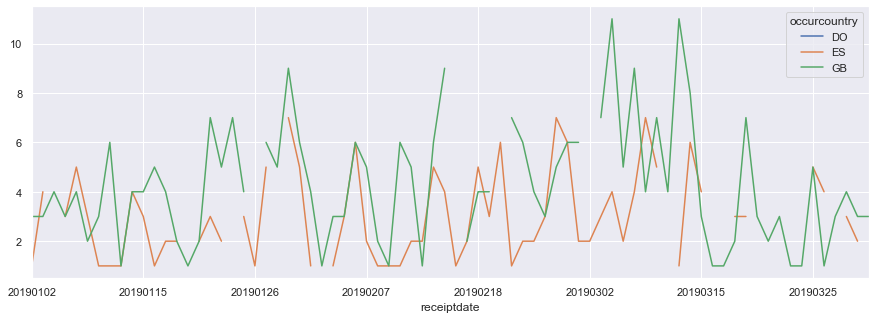

In [71]:
df = df_events_by_countries.copy()

ctries = ['DO', 'GB', 'ES']
df = df[df['occurcountry'].isin(ctries)]

df['count'] = 1
# df['receivedate']= pd.to_datetime(df['receivedate']) 
# date_ref = "receivedate"
date_ref = "receiptdate"
df.set_index(date_ref)

df.groupby([date_ref, 'occurcountry']).count()["count"].unstack().plot(figsize=(15,5))


(12000, 12)
(5961, 12)


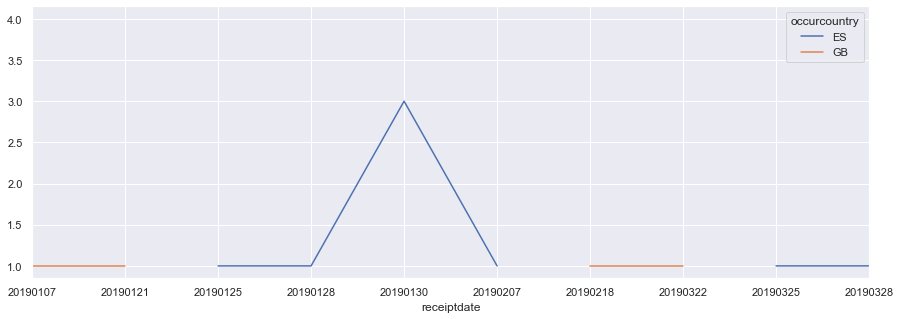

In [86]:
"""
'1': "The adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition"
'2': "The adverse event did not result in any of the above"
"""
df = df_events_by_countries.copy()
print(df.shape)
#df.head()
df = df.loc[df['serious'] == '2']
print(df.shape)

ctries = ['DO', 'GB', 'ES']
df = df[df['occurcountry'].isin(ctries)]

df['count'] = 1
# df['receivedate']= pd.to_datetime(df['receivedate']) 
# date_ref = "receivedate"
date_ref = "receiptdate"
df.set_index(date_ref)

df.groupby([date_ref, 'occurcountry']).count()["count"].unstack().plot(figsize=(15,5))


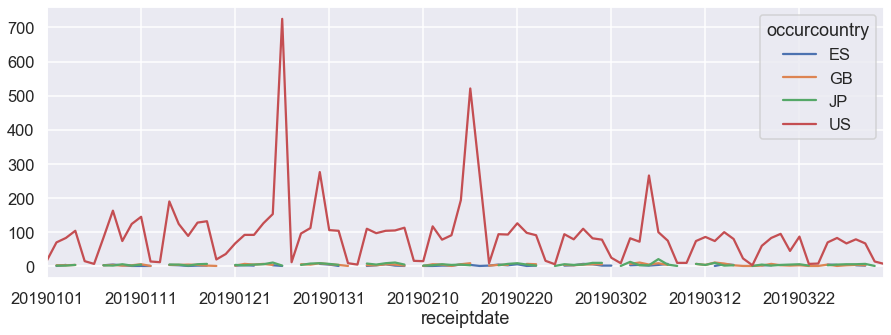

In [43]:
df = df_events_by_countries.copy()

ctries = ['US', 'JP', 'GB', 'ES']
df = df[df['occurcountry'].isin(ctries)]


#df['receivedate']= pd.to_datetime(df['receivedate']) 
#print(df.iloc[3])

df['count'] = 1
# df['receivedate']= pd.to_datetime(df['receivedate']) 
# date_ref = "receivedate"
date_ref = "receiptdate"
df.set_index(date_ref)

df.groupby([date_ref, 'occurcountry']).count()["count"].unstack().plot(figsize=(15,5))


In [44]:
# Interactive graphs

df = df_events_by_countries.copy()

def f_get_countries_plot(x):
    df = df_events_by_countries.copy()
    ctries = list(x)
    df = df[df['occurcountry'].isin(ctries)]

    #df['receivedate']= pd.to_datetime(df['receivedate']) 
    #print(df.iloc[3])

    df['count'] = 1
    # df['receivedate']= pd.to_datetime(df['receivedate']) 
    # date_ref = "receivedate"
    date_ref = "receiptdate"
    df.set_index(date_ref)

    df.groupby([date_ref, 'occurcountry']).count()["count"].unstack().plot(figsize=(15,5))
    return list(x)

# Use 'CMD'-key in Mac OS
interact_manual(f_get_countries_plot, x=
         widgets.SelectMultiple(
             options=df["occurcountry"].unique().tolist(),
             value=[],
             #rows=10,
             description='Countries',
             disabled=False
         )
        )

interactive(children=(SelectMultiple(description='Countries', options=('US', 'DO', 'GB', 'ES', 'JP', 'TR', 'IN…

<function __main__.f_get_countries_plot(x)>

**What else we can do?**

1. plot yearly trend

2. plot seasonal trend

3. correlation between 2 countries?

(can combine with data about patients such as patients based on sex/age)

4. consider other factors, not part of the data, such as real-world events, that may explain the signal in the data such as the surged increase in #reports from US inthe last week of Jan-2019.


In [45]:
# import matplotlib as plt
def f_extra_terms(x, exact, map_name, receivedate, extra_terms="", fix_name=True):
    data = query_count_drug_indication(count_field=x, exact=exact, receivedate=receivedate, extra_terms=extra_terms)
    
    out = []
    exist = {}
    index = 0
    terms = []
    # NAIVE result
    for result in data.get('results', []):
      # print(result)
      # RESULT RESULT: consider the value is an integer
      # .. mapping to a string name, e.g. primarysource.qualification
      if (map_name):
          result['term'] = map_index_to_value(attr_list, x, result['term'])
          #print(type(result['term'])) 
      terms.append(result['term'])
    if len(terms) == 0:
        return "No record found"

    #x = np.array(terms)
    #print(len(terms))
    #print(len(np.unique(x)))
    #pp.pprint(terms)

    # REVISE RESULT
    # ... CHECK for overlapping description
    for result in data.get('results', []):
        if fix_name is True and str(result['term']).find("FOR UNKNOWN INDICATION") >= 0:
            result['term'] = "UNKNOWN INDICATION"
            if "UNKNOWN INDICATION" not in exist:
                exist["UNKNOWN INDICATION"] = index
                index = index + 1
                out.append(result)
            else:
             out[exist["UNKNOWN INDICATION"]]["count"] += result["count"]
        else:
            out.append(result)
    # print(json.dumps(out, indent=1))
    df = pd.DataFrame(out)
    print(df)
    # plt.figure(figsize=(16, 6))
    sns.set(rc={'figure.figsize':(16,6)})
    g = sns.barplot(x='term', y="count", data=df[0:12], palette=pkmn_type_colors)

    # Rotate x-labels
    g.set_xticklabels(g.get_xticklabels(), rotation=-45, fontsize=12)
    # return out # data["results"]
    import time
    file_name = time.strftime("%Y%m%d-%H%M%S")
    if x == "patient.drug.drugindication":
        file_name = "disease_areas_new"
    if "patient.drug.openfda" in x:
        file_name = "%s_new" % x
    # g.figure.savefig("images/%s.png" % file_name, bbox_inches="tight")
    df.to_pickle("images/%s.pkl" % file_name)
    
def f(x, exact, map_name, receivedate):
    extra_terms=""
    fix_name = False
    f_extra_terms(x, exact, map_name, receivedate, extra_terms, fix_name)
    

In [46]:
# Are adverse events coming from different countries?
interact(f, x=widgets.Dropdown(options=list(searchable_fields), value="primarysourcecountry"), 
         exact=True, map_name=False, receivedate="20040101+TO+20191231")

interactive(children=(Dropdown(description='x', index=63, options=('authoritynumb', 'companynumb', 'duplicate'…

<function __main__.f(x, exact, map_name, receivedate)>

## Disease areas

Disease areas can be found in 

* patient.drug.drugindication

There are two values seem overlapping [try with 'fix_name' On/Off], so I decide to merge into 'UNKNOWN INDICATION'



In [47]:
# Are adverse events associated with different disease areas?
# ... we can impose additional constraints such as 'sex' or 'pharmacologic type'
list_terms = [ ("", ""), ("female", "patient.patientsex:2"), 
              ("female [age 5-17]", "patient.patientsex:2+AND+patient.patientonsetage:[5+TO+17]"),
              ("male", "patient.patientsex:1"),
             ("pharma class: nonsteroidal/anti-inflammatory", "patient.drug.openfda.pharm_class_epc:'nonsteroidal+anti-inflammatory+drug'")]
interact(f_extra_terms, x=widgets.Dropdown(options=list(searchable_fields), value="patient.drug.drugindication"), 
         exact=True, map_name=False, 
         extra_terms=list_terms, 
         fix_name=True,
         receivedate="20040101+TO+20160601")

interactive(children=(Dropdown(description='x', index=18, options=('authoritynumb', 'companynumb', 'duplicate'…

<function __main__.f_extra_terms(x, exact, map_name, receivedate, extra_terms='', fix_name=True)>

## Disease areas?

 What are the different adverse events associated with different disease areas?
    

In [48]:
# inspect a single zipfile
# and find a way to collapse from JSON nested structure into pd.DataFrame
# -> use orderedDict is better (if py < 3.6)
import zipfile  
from collections import OrderedDict

JSON_FILENAME = './requested_openfda.json'

USE_QUERIED_DATA = False

do_io = False   # enable to add some I/O 

if USE_QUERIED_DATA:
    with open(JSON_FILENAME) as json_file:
        json_data = json.load(json_file)
else:
    # test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
    # test_file = "./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip"
    test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
    with zipfile.ZipFile(test_file, "r") as z:
       for filename in z.namelist():  
          print("File: ", test_file)  
          with z.open(filename) as f:  
             data = f.read()  
             # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
             json_data = json.loads(data.decode("utf-8"))
        
# pp.pprint(json_data)
if do_io:
    print("========")
    print("Metadata")
    print(json_data["meta"]["results"])

# records = json_data["results"][0:300]
records = json_data["results"]

# We should drop certain not-important keys
# ... some request for json_normalize but not merged yet: https://github.com/pandas-dev/pandas/pull/27262/files
# --> a better replacement is 'flatten_json' package, though it does not provide all features that I need
root_keys = \
 [
    #"receiptdate",
  #"transmissiondate",
  "transmissiondateformat",
  "receiptdateformat",
  "receivedateformat",
  "fulfillexpeditecriteria",
  "safetyreportid",
  "companynumb",
  "sender"  # "sender.senderorganization"
 ]

def delete_root_keys(record, root_keys):
    for key in root_keys:
        try:
            del record[key]
        except KeyError:
            pass
        
for record in records:
    delete_root_keys(record, root_keys)
    
if do_io:
    print("=======")
    print("(trimmed) Root keys: ", record.keys())
    print("=======")
# Some second-level keys can be removed 
# .  sender
# .  primarysource
# .  patient
# There are many subfield in 'patient' that we can ignore
ignore_fields = ["patientonsetageunit", "drugadministrationroute", 
                 "drugstartdateformat", "drugenddateformat",
                 "drugdosagetext", "unii",
                 "rxcui", "spl_set_id",
                 "product_ndc", "spl_id",
                 "application_number", "package_ndc",
                 "drugbatchnumb",
                 "drugstartdate", "drugenddate",
                 "nui", "drugauthorizationnumb",
                 "receiver",
                 "reaction", "reactionmeddrapt",
                 "drugstructuredosagenumb", "literaturereference",
                "drugseparatedosagenumb",
                "drugcumulativedosagenumb"]

def delete_sub_keys(record, ignore_fields):
    all_keys = list(record.keys())
    for key in all_keys:
        if key in ignore_fields:
            del record[key]
    for key, val in record.items():
        if isinstance(val, dict):
            delete_sub_keys(val, ignore_fields)
        if isinstance(val, list):
            for x in val:
                if isinstance(x, dict):
                    delete_sub_keys(x, ignore_fields)
    pass

for record in records:
    delete_sub_keys(record, ignore_fields)
if do_io:
    print("=======")
    print("... after deleting some fields")
    print("patient ", record["patient"])
    print("=======")
    print("=======")

# Now we can 
#print(record["patient"]["reaction"])
from flatten_json import flatten
flat_dic = flatten(record, '.')

    
dic_flattened = (flatten(d) for d in records)
import pandas as pd
df_records = pd.DataFrame(dic_flattened)

# drop all-#NULL columns
# df_records.dropna(axis=1, how='all')

pd.options.display.max_columns = None
print("Full records: ")
display(df_records)
#df.head()


disease_area_cols = [col for col in df_records.columns if 'indication' in col]
print("Column with diease areas: ")
print(disease_area_cols)

# df1 = df_records[['receivedate','primarysourcecountry', 'primarysource_reportercountry', 'occurcountry']]
df1 = df_records[['receivedate', "receiptdate", "transmissiondate"] + disease_area_cols]

# fix_name = True
for col in disease_area_cols:
    df1.loc[(df1[col].str.contains("UNKNOWN INDICATION", na=False)), col]='UNKNOWN INDICATION'
#col = 'patient_drug_0_drugindication'
#df1[col].mask(df1[col].str.contains("UNKNOWN INDICATION", na=False), 'Jazz', inplace=True)
#print(df1.iloc[0])
print("Trimmed columns DataFrame: ")
display(df1)
df_events_disease_areas = df1


File:  ./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip
Metadata
{'skip': 0, 'total': 374256, 'limit': 12000}
(trimmed) Root keys:  dict_keys(['receivedate', 'seriousnessother', 'patient', 'transmissiondate', 'occurcountry', 'receiptdate', 'primarysource', 'reporttype', 'seriousnesshospitalization', 'reportduplicate', 'receiver', 'serious', 'safetyreportversion', 'primarysourcecountry'])
... after deleting some fields
patient  {'patientonsetage': '28', 'patientsex': '1', 'drug': [{'drugrecurreadministration': '2', 'drugcharacterization': '1', 'drugadditional': '1', 'medicinalproduct': 'PONATINIB', 'activesubstance': {'activesubstancename': 'PONATINIB'}}]}
Full records: 


,receivedate,patient_patientsex,patient_drug_0_medicinalproduct,patient_drug_0_drugindication,patient_drug_0_drugcharacterization,patient_drug_0_drugstructuredosageunit,patient_drug_0_openfda_manufacturer_name_0,patient_drug_0_openfda_product_type_0,patient_drug_0_openfda_route_0,patient_drug_0_openfda_generic_name_0,patient_drug_0_openfda_brand_name_0,patient_drug_0_openfda_substance_name_0,patient_drug_0_drugintervaldosageunitnumb,patient_drug_0_actiondrug,patient_drug_0_activesubstance_activesubstancename,patient_drug_0_drugintervaldosagedefinition,patient_drug_0_drugdosageform,transmissiondate,occurcountry,receiptdate,primarysource_reportercountry,primarysource_qualification,duplicate,reporttype,reportduplicate_duplicatenumb,reportduplicate_duplicatesource,serious,safetyreportversion,primarysourcecountry,seriousnessother,patient_patientonsetage,patient_drug_0_drugadditional,patient_summary_narrativeincludeclinical,patient_drug_0_openfda_manufacturer_name_1,seriousnessdeath,patient_drug_0_drugrecurreadministration,seriousnesshospitalization,patient_drug_0_openfda_substance_name_1,patient_patientweight,patient_patientagegroup,patient_drug_1_medicinalproduct,patient_drug_1_drugindication,patient_drug_1_actiondrug,patient_drug_1_drugcharacterization,patient_drug_1_activesubstance_activesubstancename,patient_drug_1_drugdosageform,patient_drug_1_drugadditional,patient_drug_0_drugcumulativedosageunit,patient_drug_1_drugstructuredosageunit,patient_drug_1_drugintervaldosageunitnumb,patient_drug_1_drugcumulativedosageunit,patient_drug_1_drugintervaldosagedefinition,patient_drug_2_medicinalproduct,patient_drug_2_drugstructuredosageunit,patient_drug_2_drugcharacterization,patient_drug_2_drugcumulativedosageunit,patient_drug_2_actiondrug,patient_drug_2_activesubstance_activesubstancename,patient_drug_2_drugdosageform,patient_drug_2_drugadditional,patient_drug_3_medicinalproduct,patient_drug_3_drugcharacterization,patient_drug_3_drugstructuredosageunit,patient_drug_3_drugintervaldosageunitnumb,patient_drug_3_drugcumulativedosageunit,patient_drug_3_actiondrug,patient_drug_3_activesubstance_activesubstancename,patient_drug_3_drugintervaldosagedefinition,patient_drug_3_drugdosageform,patient_drug_3_drugadditional,patient_drug_4_medicinalproduct,patient_drug_4_drugcharacterization,patient_drug_4_drugstructuredosageunit,patient_drug_4_drugintervaldosageunitnumb,patient_drug_4_drugcumulativedosageunit,patient_drug_4_actiondrug,patient_drug_4_activesubstance_activesubstancename,patient_drug_4_drugintervaldosagedefinition,patient_drug_4_drugdosageform,patient_drug_4_drugadditional,patient_drug_5_medicinalproduct,patient_drug_5_drugcharacterization,patient_drug_5_drugcumulativedosageunit,patient_drug_5_actiondrug,patient_drug_5_activesubstance_activesubstancename,patient_drug_5_drugdosageform,patient_drug_5_drugadditional,patient_drug_6_medicinalproduct,patient_drug_6_drugcharacterization,patient_drug_6_drugintervaldosageunitnumb,patient_drug_6_drugcumulativedosageunit,patient_drug_6_actiondrug,patient_drug_6_activesubstance_activesubstancename,patient_drug_6_drugintervaldosagedefinition,patient_drug_6_drugdosageform,patient_drug_6_drugadditional,patient_drug_7_medicinalproduct,patient_drug_7_drugcharacterization,patient_drug_7_drugcumulativedosageunit,patient_drug_7_actiondrug,patient_drug_7_activesubstance_activesubstancename,patient_drug_7_drugdosageform,patient_drug_7_drugadditional,authoritynumb,seriousnesslifethreatening,patient_drug_2_drugindication,patient_drug_3_drugindication,seriousnessdisabling,patient_drug_1_openfda_manufacturer_name_0,patient_drug_1_openfda_product_type_0,patient_drug_1_openfda_route_0,patient_drug_1_openfda_generic_name_0,patient_drug_1_openfda_brand_name_0,patient_drug_1_openfda_substance_name_0,patient_drug_1_drugrecurreadministration,patient_drug_0_openfda_route_1,patient_drug_2_openfda_manufacturer_name_0,patient_drug_2_openfda_product_type_0,patient_drug_2_openfda_route_0,patient_drug_2_openfda_generic_name_0

Column with diease areas: 
['patient_drug_0_drugindication', 'patient_drug_1_drugindication', 'patient_drug_2_drugindication', 'patient_drug_3_drugindication', 'patient_drug_4_drugindication', 'patient_drug_5_drugindication', 'patient_drug_6_drugindication', 'patient_drug_7_drugindication', 'patient_drug_8_drugindication', 'patient_drug_9_drugindication', 'patient_drug_10_drugindication', 'patient_drug_11_drugindication', 'patient_drug_12_drugindication', 'patient_drug_13_drugindication']
Trimmed columns DataFrame: 


/Users/tmhoangtus.ibm.com/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/tmhoangtus.ibm.com/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,receivedate,receiptdate,transmissiondate,patient_drug_0_drugindication,patient_drug_1_drugindication,patient_drug_2_drugindication,patient_drug_3_drugindication,patient_drug_4_drugindication,patient_drug_5_drugindication,patient_drug_6_drugindication,patient_drug_7_drugindication,patient_drug_8_drugindication,patient_drug_9_drugindication,patient_drug_10_drugindication,patient_drug_11_drugindication,patient_drug_12_drugindication,patient_drug_13_drugindication
0,20190227,20190227,20190418,UNKNOWN INDICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20190227,20190301,20190418,SEPTO-OPTIC DYSPLASIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20190227,20190227,20190418,UNKNOWN INDICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20190213,20190213,20190417,TYPE 1 DIABETES MELLITUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20190213,20190213,20190417,INDUCTION OF CERVIX RIPENING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,20190129,20190302,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11996,20190129,20190129,20190417,SELF-MEDICATION,SELF-MEDICATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11997,20190130,20190206,20190417,TYPE 2 DIABETES MELLITUS,TYPE 2 DIABETES MELLITUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11998,20190130,20190130,20190417,BONE MARROW CONDITIONING REGIMEN,BONE MARROW CONDITIONING REGIMEN,BONE MARROW CONDITIONING REGIMEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Use this to easily select the disease areas of interest
from IPython.display import display
from ipywidgets import Layout

# -> the 'new' file is the dynamically created file
# disease_areas_df = pd.read_pickle("./images/disease_areas.pkl")
disease_areas_df = pd.read_pickle("./images/disease_areas_new.pkl")
df = disease_areas_df
# NOTE: This is the limit of one query '99', so there can be more disease areas yet with less prevalence
# display(df)
def f_get_disease_name(x):
    return x
#interact(f_get_disease_name, x=df["term"].to_list())
# Use 'CMD'-key in Mac OS
a = interact(f_get_disease_name, x=
         widgets.SelectMultiple(
             options=df["term"].unique().tolist(),
             value=[],
             #rows=10,
             description='Disease areas',
             disabled=False,
             row = 10,
             layout={'height': '200px', 'width': '500px'}  # Layout(overflow_y="visible")
         )
        )
display(a)


interactive(children=(SelectMultiple(description='Disease areas', layout=Layout(height='200px', width='500px')…

<function __main__.f_get_disease_name(x)>

In [139]:
# copy the selected diseases into 'diseases'
diseases = ['PAIN', 'RHEUMATOID ARTHRITIS', 'DEPRESSION', "HYPERTENSION", "ASTHMA", 'TYPE 2 DIABETES MELLITUS', 'BACK PAIN', 'MIGRAINE']

df = df_events_disease_areas.copy()
print(df.shape)

df.filter(regex='drugindication$',axis=1)
mask = df.isin(diseases).any(axis=1)
df = df[mask]
# drop all-NULL columns
df.dropna(axis=1, how='all')

print(df.shape)

df['drugindication'] = df[disease_area_cols].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
df = df.drop(disease_area_cols, axis=1)

date_ref = "receiptdate"
# df.set_index(date_ref)
df[date_ref]= pd.to_datetime(df[date_ref]) 
# 
df = df.set_index(date_ref)['drugindication'].str.get_dummies(',')
df = df[diseases]
# df[date_ref] =  df_events_disease_areas[date_ref].copy()
display(df)


(12000, 17)
(691, 17)


,PAIN,RHEUMATOID ARTHRITIS,DEPRESSION,HYPERTENSION,ASTHMA,TYPE 2 DIABETES MELLITUS,BACK PAIN,MIGRAINE
receiptdate,,,,,,,,
2019-02-04,0,0,0,0,1,0,0,0
2019-03-15,1,0,0,0,0,0,0,0
2019-01-18,0,0,0,1,0,0,0,0
2019-02-19,1,0,1,0,0,0,0,0
2019-03-25,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2019-03-01,0,1,0,0,0,0,0,0
2019-03-31,0,1,0,0,0,0,0,0
2019-02-01,0,0,0,0,0,0,0,1


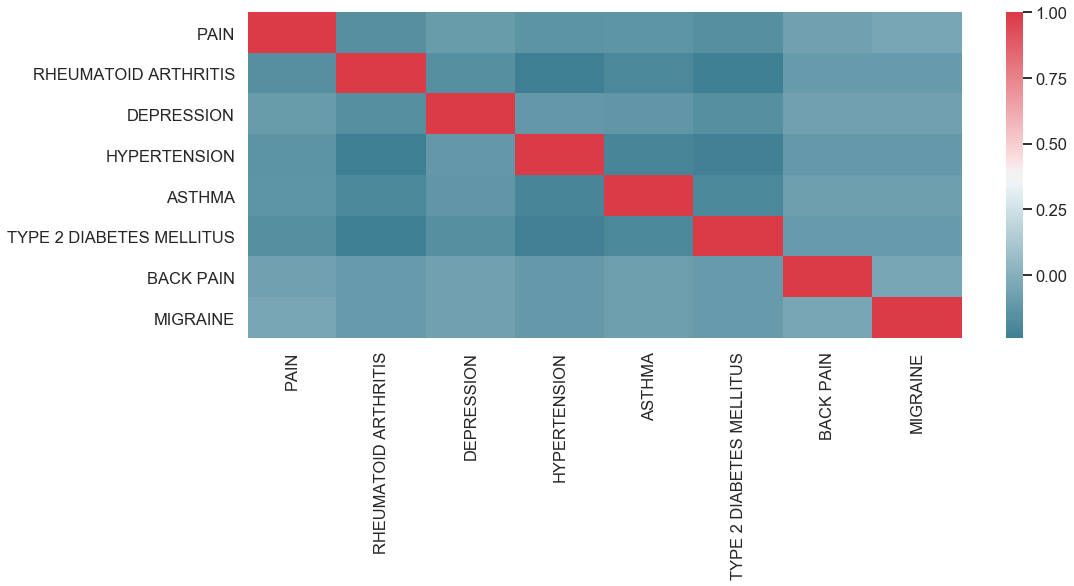

In [130]:
corr = df.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

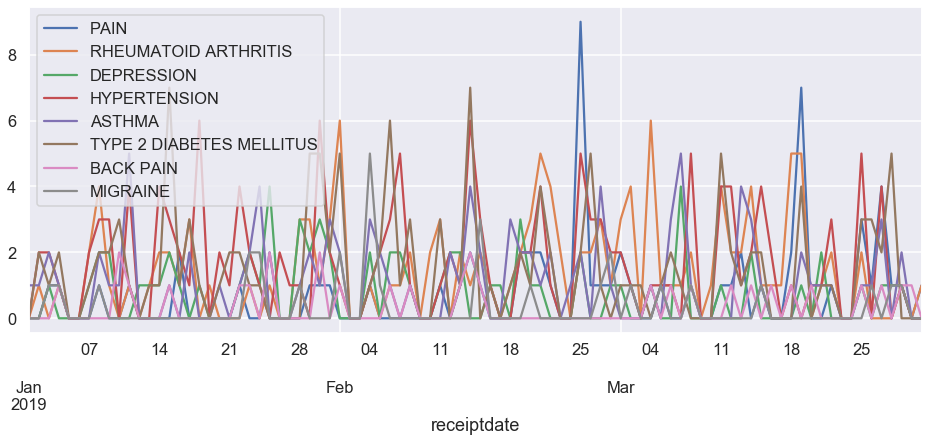

In [131]:
# Plot of events from certain diseases over time
# df.resample('M').sum()
df.resample('D').sum().plot()


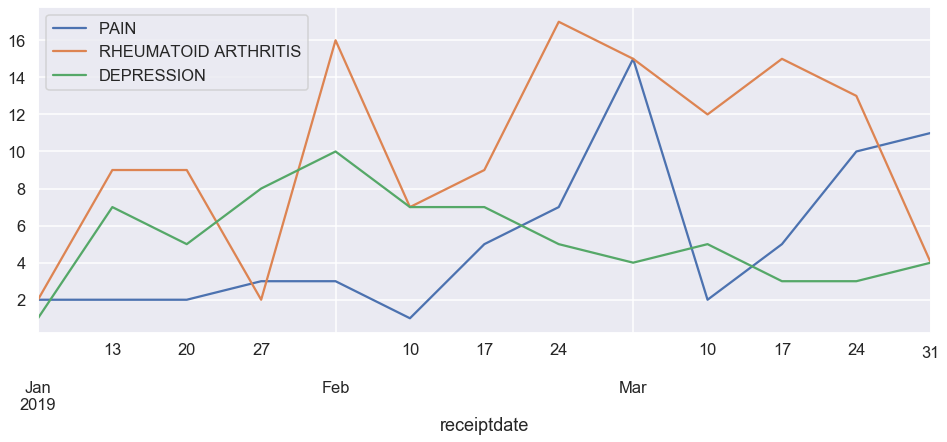

In [142]:
# Plot of events from certain diseases over time
diseases = ['PAIN', 'RHEUMATOID ARTHRITIS', 'DEPRESSION']
df = df[diseases]
# drop all-NULL columns
df.dropna(axis=1, how='all')
df.resample('W').sum().plot()


## Drug use?

Drug names can be found in 

* patient.drug.medicinalproduct

    This may be the valid trade name of the product (such as `ADVIL` or `ALEVE`) or the generic name (such as `IBUPROFEN`). This field is not systematically normalized. It may contain misspellings or idiosyncratic descriptions of drugs, such as combination products such as those used for birth control.
    
* patient.drug.openfda.brand_name
    
    Brand or trade name of the drug product.
    
* patient.drug.openfda.generic_name
    
    Generic name of the drug product.
    
* patient.drug.openfda.nui
    Unique identifier applied to a drug concept within the National Drug File Reference Terminology (NDF-RT)."
    
* patient.drug.activesubstance.activesubstancename

    Product active ingredient, which may be different than other drug identifiers (when provided)
    
* patient.drug.drugcharacterization
    the result tells whether the drug is the main cause of the event [not validated by FDA]
     value:
                  '1': "Suspect (the drug was considered by the reporter to be the cause)"
                  '2': "Concomitant (the drug was reported as being taken along with the suspect drug)"
                  '3': "Interacting (the drug was considered by the reporter to have interacted with the suspect drug)"
    
   
 What drugs tend to be taken together?

In [146]:
# Remember that this only returns records in that the field is present. There are several records in that certain fields are missing.
# --> it also create a pickle file for the drug names to be used later
interact(f, x=widgets.Dropdown(options=list(searchable_fields), value="patient.drug.openfda.generic_name"), 
         exact=True, map_name=False, # plot_index=[],
         receivedate="20040101+TO+20191201")



interactive(children=(Dropdown(description='x', index=33, options=('authoritynumb', 'companynumb', 'duplicate'…

<zipfile.ZipExtFile [closed]>

### BRAND NAME

REMARKS:

* There are records that does not have any 'brand_name' drug, e.g. maybe it uses 'generic_drug'. So we drop them from the analysis

Example: 2019 Q1 file with 12,000 records, in that only 6889 records have brand-name drugs.

* Records that uses only one drug are also dropped.

* There are records in that the same drug is listed multiple times, e.g. record 11989. It is considered as single drug being used.

In [54]:
# This shows record 11989
import zipfile  
from collections import OrderedDict
# test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
# test_file = "./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip"
test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
with zipfile.ZipFile(test_file, "r") as z:
   for filename in z.namelist():  
      print("File: ", test_file)  
      with z.open(filename) as f:  
         data = f.read()  
         # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
         json_data = json.loads(data.decode("utf-8"))
        
# pp.pprint(json_data)
print("========")
print("Metadata")
print(json_data["meta"]["results"])

# records = json_data["results"][0:300]
records = json_data["results"]
records[11989]

File:  ./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip
Metadata
{'skip': 0, 'total': 374256, 'limit': 12000}


{'receivedate': '20190201',
 'seriousnessother': '1',
 'patient': {'reaction': [{'reactionmeddrapt': 'Seizure',
    'reactionmeddraversionpt': '21.1',
    'reactionoutcome': '6'},
   {'reactionmeddrapt': 'Rash',
    'reactionmeddraversionpt': '21.1',
    'reactionoutcome': '1'}],
  'patientsex': '2',
  'drug': [{'medicinalproduct': 'APTIOM',
    'drugadministrationroute': '048',
    'drugdosagetext': '1200 MG, UNK',
    'drugstructuredosageunit': '003',
    'openfda': {'manufacturer_name': ['Sunovion Pharmaceuticals Inc.'],
     'unii': ['BEA68ZVB2K'],
     'product_type': ['HUMAN PRESCRIPTION DRUG'],
     'rxcui': ['1482523',
      '1482521',
      '1482527',
      '1482525',
      '1491643',
      '1491642',
      '1482513',
      '1482507',
      '1482517',
      '1482515'],
     'spl_set_id': ['3d0c9554-eaeb-4694-8089-00133fcadce3'],
     'route': ['ORAL'],
     'generic_name': ['ESLICARBAZEPINE ACETATE'],
     'brand_name': ['APTIOM'],
     'product_ndc': ['63402-248',
      '6340

In [147]:
# inspect a single zipfile
# and find a way to collapse from JSON nested structure into pd.DataFrame
# -> use orderedDict is better (if py < 3.6)
import zipfile  
from collections import OrderedDict

JSON_FILENAME = './requested_openfda.json'

USE_QUERIED_DATA = False

do_io = False   # enable to add some I/O 

if USE_QUERIED_DATA:
    with open(JSON_FILENAME) as json_file:
        json_data = json.load(json_file)
else:
    # test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
    # test_file = "./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip"
    test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
    with zipfile.ZipFile(test_file, "r") as z:
       for filename in z.namelist():  
          print("File: ", test_file)  
          with z.open(filename) as f:  
             data = f.read()  
             # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
             json_data = json.loads(data.decode("utf-8"))
        
# pp.pprint(json_data)
if do_io:
    print("========")
    print("Metadata")
    print(json_data["meta"]["results"])

# records = json_data["results"][0:300]
records = json_data["results"]

# We should drop certain not-important keys
# ... some request for json_normalize but not merged yet: https://github.com/pandas-dev/pandas/pull/27262/files
# --> a better replacement is 'flatten_json' package, though it does not provide all features that I need
root_keys = \
 [
    #"receiptdate",
  #"transmissiondate",
  "transmissiondateformat",
  "receiptdateformat",
  "receivedateformat",
  "fulfillexpeditecriteria",
  "safetyreportid",
  "companynumb",
  "sender"  # "sender.senderorganization"
 ]

def delete_root_keys(record, root_keys):
    for key in root_keys:
        try:
            del record[key]
        except KeyError:
            pass
        
for record in records:
    delete_root_keys(record, root_keys)
    
if do_io:
    print("=======")
    print("(trimmed) Root keys: ", record.keys())
    print("=======")
# Some second-level keys can be removed 
# .  sender
# .  primarysource
# .  patient
# There are many subfield in 'patient' that we can ignore
ignore_fields = ["patientonsetageunit", "drugadministrationroute", 
                 "drugstartdateformat", "drugenddateformat",
                 "drugdosagetext", "unii",
                 "rxcui", "spl_set_id",
                 "product_ndc", "spl_id",
                 "application_number", "package_ndc",
                 "drugbatchnumb",
                 "drugstartdate", "drugenddate",
                 "nui", "drugauthorizationnumb",
                 "receiver",
                 "reaction", "reactionmeddrapt",
                 "drugstructuredosagenumb", "literaturereference",
                "drugseparatedosagenumb",
                "drugcumulativedosagenumb"]

def delete_sub_keys(record, ignore_fields):
    all_keys = list(record.keys())
    for key in all_keys:
        if key in ignore_fields:
            del record[key]
    for key, val in record.items():
        if isinstance(val, dict):
            delete_sub_keys(val, ignore_fields)
        if isinstance(val, list):
            for x in val:
                if isinstance(x, dict):
                    delete_sub_keys(x, ignore_fields)
    pass

for record in records:
    delete_sub_keys(record, ignore_fields)
    
if do_io:
    print("=======")
    print("... after deleting some fields")
    print("patient ", record["patient"])
    print("=======")
    print("=======")

# Now we can 
#print(record["patient"]["reaction"])
from flatten_json import flatten
flat_dic = flatten(record, '.')

    
dic_flattened = (flatten(d) for d in records)
import pandas as pd
df_records = pd.DataFrame(dic_flattened)

# drop all-#NULL columns
# df_records.dropna(axis=1, how='all')

pd.options.display.max_columns = None
print("Full records: ")
# display(df_records)
#df.head()



disease_area_cols = [col for col in df_records.columns if 'drugindication' in col]
print("Column with disease areas: ")
print(disease_area_cols)

## ---> choose between "brand_name" and "generic_name"
drug_type = "brand_name"
drug_name_cols = [col for col in df_records.columns if drug_type in col]
print("Column with drug names: ")
print(drug_name_cols)

# ===================================
# SELECT COLUMNS of INTEREST
# ===================================
# df1 = df_records[['receivedate','primarysourcecountry', 'primarysource_reportercountry', 'occurcountry']]
df1 = df_records[['receivedate', "receiptdate", "transmissiondate"] + drug_name_cols]

# df1 = df_records[['receivedate','primarysourcecountry', 'primarysource_reportercountry', 'occurcountry']]
#df1 = df_records[['receivedate', "receiptdate", "transmissiondate"] + disease_area_cols]

# fix_name = True
for col in disease_area_cols:
    if col in df1.columns.values:
        df1.loc[(df1[col].str.contains("UNKNOWN INDICATION", na=False)), col]='UNKNOWN INDICATION'
        
for col in drug_name_cols:
    if col in df1.columns.values:
        # if not df1.loc[(df1[col].str.contains(", ", na=False)), col].empty:
        #     display(df1.loc[(df1[col].str.contains(", ", na=False)), col])
        if not df1.loc[(df1[col].str.contains("AND ", na=False)), col].empty:
            display(df1.loc[(df1[col].str.contains("AND ", na=False)), col])
        # df1.loc[(df1[col].str.contains("UNKNOWN INDICATION", na=False)), col]='UNKNOWN INDICATION'
        
        
# col = 'patient_drug_0_drugindication'
#df1[col].mask(df1[col].str.contains("UNKNOWN INDICATION", na=False), 'Jazz', inplace=True)
#print(df1.iloc[0])
print("Trimmed columns DataFrame: ")
display(df1)


#### ========
### FURTHER PROCESSING
#### ========
df_events_drug_names = df1

df = df_events_drug_names.copy()
print(df.shape)

# diseases = ['PAIN', 'RHEUMATOID ARTHRITIS', 'DEPRESSION']
# -> get only columns with drug names
df.filter(regex='brand_name_[0-9]+$',axis=1)  # drug_type
#mask = df.isin(diseases).any(axis=1)
#df = df[mask]
# drop all-NULL columns
df.dropna(axis=1, how='all')

#df = df[df.line_race != 0]
#mask = df.loc[df[disea_area_cols].isin(["PRODUCT USED FOR UNKNOWN INDICATION"])]
# for x in disea_area_cols:
#     mask = df.loc[df[x] != "PRODUCT USED FOR UNKNOWN INDICATION"]
#     print(mask)
#     # df = df[mask]
#     # print(df.shape)
#print(df["patient_drug_0_drugindication"].unique())
print(df.shape)

df[drug_type] = df[drug_name_cols].apply(
    lambda x: ",".join(set(','.join(x.dropna().astype(str)).split(","))),
    axis=1
)
df = df.drop(drug_name_cols, axis=1)
# print(disease_area_cols)

## --> remove records that have no brand_name drugs
df[drug_type].replace('', np.nan, inplace=True)
df.dropna(subset=[drug_type], inplace=True)

print("After processing columns: ")
display(df)
# df[df.isin(["AND CAFFEINE"]).any(axis=1)]

# #df['receivedate']= pd.to_datetime(df['receivedate']) 
# #print(df.iloc[3])
# 
# df['count'] = 1
# # df['receivedate']= pd.to_datetime(df['receivedate']) 
# # date_ref = "receivedate"

date_ref = "receiptdate"
# df.set_index(date_ref)
df[date_ref]= pd.to_datetime(df[date_ref]) 
# 
df1 = df.set_index(date_ref)[drug_type].str.get_dummies(',')

# --> limits the number of columns
#df = df[diseases]

display(df1)

#### ========
### FURTHER PROCESSING
#### ========
df_events_drug_names = df1

File:  ./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip
Full records: 
Column with disease areas: 
['patient_drug_0_drugindication', 'patient_drug_1_drugindication', 'patient_drug_2_drugindication', 'patient_drug_3_drugindication', 'patient_drug_4_drugindication', 'patient_drug_5_drugindication', 'patient_drug_6_drugindication', 'patient_drug_7_drugindication', 'patient_drug_8_drugindication', 'patient_drug_9_drugindication', 'patient_drug_10_drugindication', 'patient_drug_11_drugindication', 'patient_drug_12_drugindication', 'patient_drug_13_drugindication']
Column with drug names: 
['patient_drug_0_openfda_brand_name_0', 'patient_drug_1_openfda_brand_name_0', 'patient_drug_2_openfda_brand_name_0', 'patient_drug_0_openfda_brand_name_1', 'patient_drug_0_openfda_brand_name_2', 'patient_drug_1_openfda_brand_name_1', 'patient_drug_1_openfda_brand_name_2', 'patient_drug_3_openfda_brand_name_0', 'patient_drug_4_openfda_brand_name_0', 'patient_drug_5_openfda_brand_name_0', 'pat

1442     ALKA-SELTZER PLUS MAXIMUM STRENGTH COUGH AND M...
3556     GOLD BOND MEDICATED CRACKED SKIN FILL AND PROTECT
3905     GOLD BOND MEDICATED CRACKED SKIN FILL AND PROTECT
4615                           PIPERACILLIN AND TAZOBACTAM
5090              GOLD BOND MEDICATED PAIN AND ITCH RELIEF
6638         GOLD BOND ULTIMATE HAND SANITIZER MOISTURIZER
8695                           CORICIDIN HBP DAY AND NIGHT
9980     GOLD BOND MEDICATED CRACKED SKIN FILL AND PROTECT
10260    POTASSIUM CHLORIDE IN DEXTROSE AND SODIUM CHLO...
Name: patient_drug_0_openfda_brand_name_0, dtype: object

7132    ALKA-SELTZER PLUS MAXIMUM STRENGTH COUGH AND M...
Name: patient_drug_1_openfda_brand_name_0, dtype: object

7132    ALKA-SELTZER PLUS MAXIMUM STRENGTH COUGH AND M...
Name: patient_drug_2_openfda_brand_name_0, dtype: object

Trimmed columns DataFrame: 


,receivedate,receiptdate,transmissiondate,patient_drug_0_openfda_brand_name_0,patient_drug_1_openfda_brand_name_0,patient_drug_2_openfda_brand_name_0,patient_drug_0_openfda_brand_name_1,patient_drug_0_openfda_brand_name_2,patient_drug_1_openfda_brand_name_1,patient_drug_1_openfda_brand_name_2,patient_drug_3_openfda_brand_name_0,patient_drug_4_openfda_brand_name_0,patient_drug_5_openfda_brand_name_0,patient_drug_8_openfda_brand_name_0,patient_drug_3_openfda_brand_name_1,patient_drug_6_openfda_brand_name_0,patient_drug_3_openfda_brand_name_2,patient_drug_7_openfda_brand_name_0,patient_drug_2_openfda_brand_name_1,patient_drug_2_openfda_brand_name_2,patient_drug_9_openfda_brand_name_0,patient_drug_10_openfda_brand_name_0,patient_drug_11_openfda_brand_name_0,patient_drug_12_openfda_brand_name_0,patient_drug_13_openfda_brand_name_0,patient_drug_14_openfda_brand_name_0,patient_drug_15_openfda_brand_name_0,patient_drug_16_openfda_brand_name_0,patient_drug_4_openfda_brand_name_1
0,20190227,20190227,20190418,SAXENDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20190227,20190301,20190418,GENOTROPIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20190227,20190227,20190418,ATACAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20190213,20190213,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20190213,20190213,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,20190129,20190302,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11996,20190129,20190129,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11997,20190130,20190206,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11998,20190130,20190130,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(12000, 29)
(12000, 29)
After processing columns: 


,receivedate,receiptdate,transmissiondate,brand_name
0,20190227,20190227,20190418,SAXENDA
1,20190227,20190301,20190418,GENOTROPIN
2,20190227,20190227,20190418,ATACAND
5,20190213,20190213,20190417,COSOPT PF
6,20190214,20190214,20190417,ADVAIR DISKUS
...,...,...,...,...
11988,20190201,20190201,20190417,PROPRANOLOL
11989,20190201,20190201,20190417,APTIOM
11990,20190128,20190220,20190417,SYNAGIS
11991,20190128,20190128,20190417,REMICADE


,ABILIFY MAINTENA,ABREVA,ACT DRY MOUTH ANTICAVITY FLUORIDE,ACTHAR,ACTIVASE,ACTOS,ADLYXIN,ADRENALIN,ADVAIR DISKUS,ADVANCED EYE RELIEF DRY EYE REJUVENATION,ADZENYS XR-ODT,AKYNZEO,ALAVERT ALLERGY,ALDACTAZIDE,ALDACTONE,ALINIA,ALISKIREN,ALKA-SELTZER PLUS MAXIMUM STRENGTH COUGH AND MUCUS DM,ALLI,ALPRAZOLAM ER,ALTACE,ALUNBRIG,AMARYL,AMITIZA,AMPYRA,ANDEXXA,APTIOM,AQUASOL A,ARIKAYCE,AROMASIN,ARTHROTEC,ASP,ASPERCREME WITH LIDOCAINE XL,ASTELIN,ATACAND,ATROVENT HFA,AZILECT,AZURETTE,BACTRIM,BASAGLAR,BENZOIN,BESPONSA,BETHKIS,BICNU,BILIOUSNESS DIARRHEA,BREO ELLIPTA,BRIDION,BRIMONIDINE,BRINEURA,BRIVIACT,BYDUREON,CABOMETYX,CAMRESE,CANASA,CANCIDAS,CANDESARTAN,CAPECITABINE 150MG,CAPECITABINE 500MG,CAPRELSA,CARAFATE,CARDURA,CARDURA XL,CARDUUS MARIANUS,CATAPRES,CEFUROXIME SODIUM,CERDELGA,CEREZYME,CHAPSTICK CLASSIC STRAWBERRY,CHILDRENS SUDAFED NASAL DECONGESTANT,CHILDRENS ZYRTEC,CHLORPROMAZINUM,CHORIONIC GONADOTROPIN,CISATRACURIUM,CLADRIBINE,CLARAVIS,CLINDESSE,CLONIDINE TRANSDERMAL SYSTEM,COGENTIN,COLACE,COMETRIQ,COMTAN,CORICIDIN HBP DAY AND NIGHT,CORTISPORIN,COSMEGEN,COSOPT,COSOPT PF,COUMADIN,CREON,CRESEMBA,CRESTOR,CUBICIN,CYCLOBENZAPRINE,CYCLOBENZAPRINE HYDROCHLORIDE,CYCLOSET,CYKLOKAPRON,DACOGEN,DALIRESP,DALVANCE,DANTRIUM,DANTROLENE,DARAPRIM,DASETTA 1/35,DASETTA 7/7/7,DATSCAN,DECADRON,DEFEROXAMINE,DEFINITY,DEFITELIO,DELZICOL,DEPO-MEDROL,DEPO-PROVERA,DETROL LA,DEXILANT,DIACOMIT,DICLOFENAC,DICLOFENAC EPOLAMINE,DICLOFENAC SODIUM,DIFICID,DIPRIVAN,DOANS EXTRA STRENGTH,DOBUTAMINE HYDROCHLORIDE IN DEXTROSE,DORZOLAMIDE HCL,DOXORUBICIN HYDROCHLORIDE,DOXYCYCLINE HYCLATE DELAYED RELEASE,DOXYCYCLINE MONOHYDRATE,DRAMAMINE - N,DRAXIMAGE MAA,DULCOEASE,DULCOLAX STOOL SOFTENER,DYANAVEL XR,EDECRIN,ELAPRASE,ELIDEL,ELLA,ELMIRON,EMSAM,ENDOCET,EPIDUO,EPIPEN,EPIPEN JR,EQUATE NICOTINE,EQUATE STOMACH RELIEF,EQUETRO,ERIVEDGE,ESKATA,EUCRISA,EUTHYROX,EXELON,EXONDYS 51,EXPAREL,EXTRANEAL,FAZACLO,FERAHEME,FERRUM METALLICUM,FIBER,FIORICET,FLECTOR,FLUDARABINE,FLUTICASONE,FOSCAVIR,GAVISCON,GAVISCON EXTRA STRENGTH,GAVISCON REGULAR STRENGTH,GENGRAF,GENOTROPIN,GENVOYA,GLEOSTINE,GLIADEL,GLUCAGEN,GLUCOPHAGE,GLUCOPHAGE XR,GLUCOTROL,GLUCOTROL XL,GLYNASE,GOCOVRI,GOLD BOND MEDICATED CRACKED SKIN FILL AND PROTECT,GOLD BOND MEDICATED PAIN AND ITCH RELIEF,GOLD BOND ULTIMATE 5-IN-1 FACE,GOLD BOND ULTIMATE HAND SANITIZER MOISTURIZER,GOPRELTO,GRANIX,HABITROL STEP 1,HABITROL STEP 2,HABITROL STEP 3,HAEMONETICS ANTICOAGULANT SODIUM CITRATE,HALAVEN,HETLIOZ,HICON,HORIZANT,HYDROXYZINE HYDROCHLORIDE,HYPERCARE,ICLUSIG,IMODIUM A-D,INFANTS TYLENOL,INJECTAFER,INOMAX,INSPRA,INTERFERON,INVEGA SUSTENNA,INVEGA TRINZA,INVOKAMET,ISENTRESS,ISTODAX,JEVTANA,KALBITOR,KALYDECO,KANUMA,KERYDIN,KINERET,KLONOPIN,LABETALOL HYDROCHLORIDE,LACRISERT,LAMISIL AT,LAMISIL AT FOR JOCK ITCH,LASIX,LATUDA,LEUCOVORIN,LEUKERAN,LEUKINE,LEVO-T,LEVOTHYROXINE,LEXAPRO,LEXISCAN,LIBTAYO,LIDOCAINE PATCH,LIDODERM,LINCOCIN,LINZESS,LIOTHYRONINE,LIPIODOL,LITHIUM,LOKELMA,LOMOTIL,LONSURF,LOPID,LOPRESSOR,LORBRENA,LORCET,LOTRIMIN ULTRA ANTIFUNGAL,LOW-OGESTREL,LUMOXITI,LUPRON DEPOT,LUTATHERA,MAKENA,MALARONE,MAVENCLAD,MEKTOVI,MENOPUR,MENS ROGAINE EXTRA STRENGTH UNSCENTED,MERCILON,METAMUCIL THERAPY FOR REGULARITY,METFORMIN HCL,MIBELAS 24 FE,MICARDIS,MILK OF MAGNESIA ORIGINAL,MINIPRESS,MIRVASO,MONUROL,MYALEPT,MYORISAN,MYOVIEW,MYRBETRIQ,NAFTIN,NAGLAZYME,NALFON,NAMZARIC,NARDIL,NATPARA (PARATHYROID HORMONE),NEO-SYNEPHRINE EXTRA STRENGTH,NEOPROFEN,NERLYNX,NEUPRO,NEUTROGENA OIL FREE ACNE WASH PINK GRAPEFRUIT FACIAL CLEANSER,NEXIUM 24HR,NICODERM CQ,NICORETTE CINNAMON SURGE,NICORETTE MINT,NICORETTE SPEARMINT BURST,NITROSTAT,NORDITROPIN,NORVASC,NOXAFIL,NUPERCAINAL,NUTRILIPID I.V. FAT EMULSION,NUVESSA,OCALIVA,ODEFSEY,OFIRMEV,OLOPATADINE,OMEGAVEN,OMNIPAQUE,ONCASPAR,ONEXTON,ONFI,ONZETRA,OPSUMIT,ORAQIX,ORTHO TRI CYCLEN LO,OSCILLOCOCCINUM,OVIDREL,OXISTAT,OXTELLAR XR,OXYTROL,PACERONE,PALYNZIQ,PAMELOR,PANHEMATIN,PAREMYD,PENNSAID,PERCOCET,PERJETA,PHENERGAN,PIPERACILLIN AND TAZOBACTAM,PITOCIN,PLAQUENIL,POTASSIUM CHLORIDE IN DEXTROSE AND SODIUM CHLORIDE,PRADAXA,PRAMOSONE

In [148]:
#NOTE: If we disable the removing of no brand-name drugs records, then this show the the number of records not having brand-name drugs
#df.loc[0:10, ["brand_name"]]
# print(df_records[drug_name_cols].shape)
# 
# print(df_records[drug_name_cols].dropna(how='all').shape)

In [114]:
# select on records that use at least 2 drugs
df = df_events_drug_names
print(df.shape)
tmp = df[df.sum(axis=1) >= 2]

print(tmp.shape)
tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
print(tmp.shape)
display(tmp)

corrMatrix = tmp.corr()

(6889, 470)
(329, 470)
(329, 182)


,ABILIFY MAINTENA,ACTOS,ADVAIR DISKUS,ALDACTAZIDE,ALDACTONE,ALINIA,AMARYL,AMPYRA,AQUASOL A,AZILECT,BACTRIM,BASAGLAR,BETHKIS,BILIOUSNESS DIARRHEA,BREO ELLIPTA,BYDUREON,CABOMETYX,CANDESARTAN,CAPECITABINE 150MG,CAPECITABINE 500MG,CARDURA,CARDURA XL,CLADRIBINE,CLARAVIS,CLINDESSE,COLACE,COMETRIQ,COUMADIN,CRESTOR,CYCLOBENZAPRINE,CYCLOBENZAPRINE HYDROCHLORIDE,DALVANCE,DASETTA 1/35,DASETTA 7/7/7,DECADRON,DETROL LA,DEXILANT,DICLOFENAC,DICLOFENAC EPOLAMINE,DICLOFENAC SODIUM,DOXORUBICIN HYDROCHLORIDE,ENDOCET,EPIPEN,ERIVEDGE,EUTHYROX,FERRUM METALLICUM,FIBER,FIORICET,FLECTOR,GAVISCON,GAVISCON EXTRA STRENGTH,GAVISCON REGULAR STRENGTH,GENOTROPIN,GENVOYA,GLUCOPHAGE,GLUCOPHAGE XR,GLUCOTROL,GLUCOTROL XL,GLYNASE,GRANIX,HABITROL STEP 1,HABITROL STEP 2,HABITROL STEP 3,HICON,HYPERCARE,INJECTAFER,INSPRA,INTERFERON,INVEGA SUSTENNA,ISENTRESS,JEVTANA,KLONOPIN,LABETALOL HYDROCHLORIDE,LAMISIL AT,LAMISIL AT FOR JOCK ITCH,LASIX,LATUDA,LEVOTHYROXINE,LEXAPRO,LEXISCAN,LIDODERM,LIOTHYRONINE,LITHIUM,LOMOTIL,LONSURF,LOPID,LUPRON DEPOT,MAKENA,MAVENCLAD,METAMUCIL THERAPY FOR REGULARITY,METFORMIN HCL,MICARDIS,MILK OF MAGNESIA ORIGINAL,MONUROL,MYORISAN,MYRBETRIQ,NALFON,NEUPRO,NEXIUM 24HR,NORDITROPIN,NORVASC,ODEFSEY,OMEGAVEN,OMNIPAQUE,OPSUMIT,ORTHO TRI CYCLEN LO,PALYNZIQ,PAMELOR,PHENERGAN,PITOCIN,PLAQUENIL,PRADAXA,PRAXBIND,PRILOSEC OTC,PROCARDIA,PROCARDIA XL,PROCRIT,PROMETHAZINE HYDROCHLORIDE,PROPRANOLOL,PULMOZYME,REMICADE,RISPERDAL CONSTA,ROCALTROL,SAIZEN,SANDOSTATIN,SANDOSTATIN LAR DEPOT,SAXENDA,SODIUM IODIDE I 123,SODIUM IODIDE I 131 DIAGNOSTIC,SOTALOL,SPIRIVA RESPIMAT,SPRYCEL,STALEVO,STRIBILD,SYNAGIS,SYNJARDY,SYNJARDY XR,SYSTANE BALANCE,SYSTANE NIGHTTIME,TAGRISSO,TARCEVA,TAVALISSE,TERAZOSIN,TIROSINT,TIROSINT SOL,TOBI,TOBI PODHALER,TOLTERODINE TARTRATE,TOVIAZ,TRI-LINYAH,TRILEPTAL,TRINESSA,TRULICITY,TRUVADA,TWYNSTA,TYLENOL PM,TYLENOL PM EXTRA STRENGTH,ULORIC,URUSA,VAGIFEM,VALCHLOR,VELETRI,VELTASSA,VEMLIDY,VENTOLIN HFA,VIAGRA,VIREAD,VITAMIN B5,VITAMIN D,XANAX,XANAX XR,XELODA,XERMELO,XOPENEX,XTANDI,XYREM,XYZAL,YONDELIS,ZOLINZA,ZORVOLEX,ZYDELIG,ZYRTEC
receiptdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2019-03-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-03-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019-03-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2019-01-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

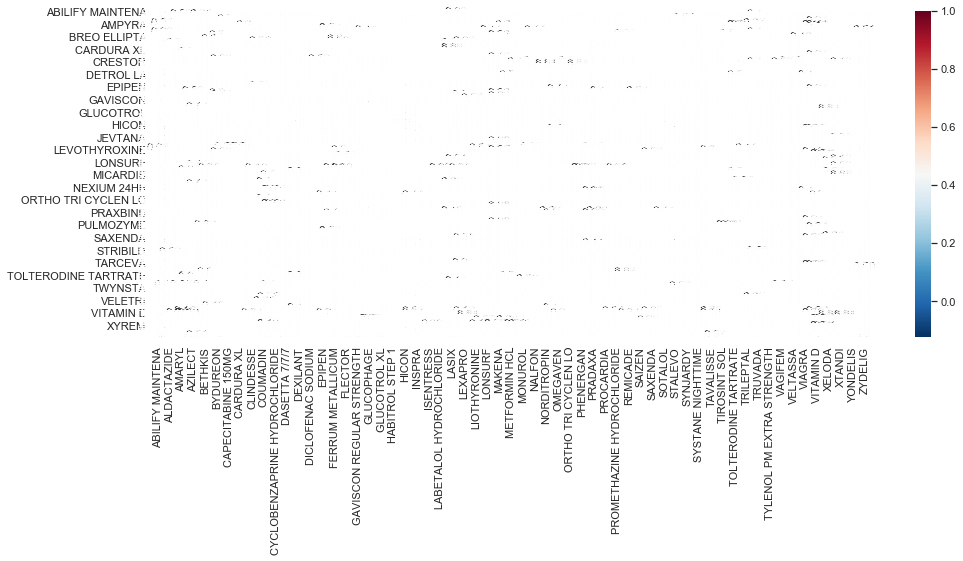

In [58]:
sns.heatmap(corrMatrix, annot=True, cmap='RdBu_r')


Example:

* NEUPRO is a dopamine agonist drug for treating Parkinson disease; and STALEVO is also used for treating Parkinson disease.

In [59]:
# sample code: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

df = tmp
print("Top pairs of drugs Absolute Correlations")
print(get_top_abs_correlations(df, 50))



Top pairs of drugs Absolute Correlations
HICON                      SODIUM IODIDE I 123                 1.000000
NEUPRO                     STALEVO                             1.000000
ULORIC                     VELTASSA                            1.000000
GENOTROPIN                 SAIZEN                              1.000000
BILIOUSNESS DIARRHEA       FERRUM METALLICUM                   1.000000
INVEGA SUSTENNA            RISPERDAL CONSTA                    1.000000
SODIUM IODIDE I 123        SODIUM IODIDE I 131 DIAGNOSTIC      1.000000
GLUCOPHAGE                 GLUCOPHAGE XR                       1.000000
HICON                      SODIUM IODIDE I 131 DIAGNOSTIC      1.000000
LOPID                      NALFON                              1.000000
GAVISCON                   GAVISCON REGULAR STRENGTH           1.000000
                           GAVISCON EXTRA STRENGTH             1.000000
DICLOFENAC                 DICLOFENAC SODIUM                   1.000000
VALCHLOR               

## GENERIC DRUG

* Based on the collapsing strategy, the columns end with "generic_name_[0-9]+$"

* How we treat drugs with similar names ? I assume they are different

ASPIRIN                                    
ASPIRIN 81 MG                              
ASPIRIN 325 MG                             

If not, then further processing is needed to map them to the same name, using the strategy like the "UNKNOWN INDICATION" scenario.

 * Consider limiting the drugs of interest by using "drug_names" list below
 
 * The input for "generic_drug" is more heterogeneity, with some use more than one drug in a given drug name [I guess because they are often prescribed together]

```console
         patient_drug_1_openfda_generic_name_0
1714     EMPAGLIFLOZIN, METFORMIN HYDROCHLORIDE
```
 
 also, some fields use "AND" term for the last drug. This makes the parsing incorrect. So, a patch is applied to remove the comma from the drug names.

```console
7248     BUTALBITAL, ACETAMINOPHEN, AND CAFFEINE
10741    ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND TENOFOVIR ALAFENAMIDE

```
 

In [115]:
# inspect a single zipfile
# and find a way to collapse from JSON nested structure into pd.DataFrame
# -> use orderedDict is better (if py < 3.6)
import zipfile  
from collections import OrderedDict

JSON_FILENAME = './requested_openfda.json'

USE_QUERIED_DATA = False

do_io = False   # enable to add some I/O 

if USE_QUERIED_DATA:
    with open(JSON_FILENAME) as json_file:
        json_data = json.load(json_file)
else:
    # test_file = "./data/2004 Q1 (part 1 of 5)/drug-event-0001-of-0005.json.zip"
    # test_file = "./data/2015 Q1 (part 1 of 25)/drug-event-0001-of-0025.json.zip"
    test_file = "./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip"
    with zipfile.ZipFile(test_file, "r") as z:
       for filename in z.namelist():  
          print("File: ", test_file)  
          with z.open(filename) as f:  
             data = f.read()  
             # json_data = json.loads(data.decode("utf-8"), object_pairs_hook=OrderedDict) 
             json_data = json.loads(data.decode("utf-8"))
        
# pp.pprint(json_data)
if do_io:
    print("========")
    print("Metadata")
    print(json_data["meta"]["results"])

# records = json_data["results"][0:300]
records = json_data["results"]

# We should drop certain not-important keys
# ... some request for json_normalize but not merged yet: https://github.com/pandas-dev/pandas/pull/27262/files
# --> a better replacement is 'flatten_json' package, though it does not provide all features that I need
root_keys = \
 [
    #"receiptdate",
  #"transmissiondate",
  "transmissiondateformat",
  "receiptdateformat",
  "receivedateformat",
  "fulfillexpeditecriteria",
  "safetyreportid",
  "companynumb",
  "sender"  # "sender.senderorganization"
 ]

def delete_root_keys(record, root_keys):
    for key in root_keys:
        try:
            del record[key]
        except KeyError:
            pass
        
for record in records:
    delete_root_keys(record, root_keys)
    
if do_io:
    print("=======")
    print("(trimmed) Root keys: ", record.keys())
    print("=======")
# Some second-level keys can be removed 
# .  sender
# .  primarysource
# .  patient
# There are many subfield in 'patient' that we can ignore
ignore_fields = ["patientonsetageunit", "drugadministrationroute", 
                 "drugstartdateformat", "drugenddateformat",
                 "drugdosagetext", "unii",
                 "rxcui", "spl_set_id",
                 "product_ndc", "spl_id",
                 "application_number", "package_ndc",
                 "drugbatchnumb",
                 "drugstartdate", "drugenddate",
                 "nui", "drugauthorizationnumb",
                 "receiver",
                 "reaction", "reactionmeddrapt",
                 "drugstructuredosagenumb", "literaturereference",
                "drugseparatedosagenumb",
                "drugcumulativedosagenumb"]

def delete_sub_keys(record, ignore_fields):
    all_keys = list(record.keys())
    for key in all_keys:
        if key in ignore_fields:
            del record[key]
    for key, val in record.items():
        if isinstance(val, dict):
            delete_sub_keys(val, ignore_fields)
        if isinstance(val, list):
            for x in val:
                if isinstance(x, dict):
                    delete_sub_keys(x, ignore_fields)
    pass

for record in records:
    delete_sub_keys(record, ignore_fields)
    
if do_io:
    print("=======")
    print("... after deleting some fields")
    print("patient ", record["patient"])
    print("=======")
    print("=======")

# Now we can 
#print(record["patient"]["reaction"])
from flatten_json import flatten
flat_dic = flatten(record, '.')

    
dic_flattened = (flatten(d) for d in records)
import pandas as pd
df_records = pd.DataFrame(dic_flattened)

# drop all-#NULL columns
# df_records.dropna(axis=1, how='all')

pd.options.display.max_columns = None
print("Full records: ")
# display(df_records)
#df.head()


disease_area_cols = [col for col in df_records.columns if 'drugindication' in col]
print("Column with disease areas: ")
print(disease_area_cols)

## ---> choose between "brand_name" and "generic_name"
drug_type = "generic_name"
drug_name_cols = [col for col in df_records.columns if drug_type in col]
print("Column with drug names: ")
print(drug_name_cols)

# ===================================
# SELECT COLUMNS of INTEREST
# ===================================
# df1 = df_records[['receivedate','primarysourcecountry', 'primarysource_reportercountry', 'occurcountry']]
df1 = df_records[['receivedate', "receiptdate", "transmissiondate"] + drug_name_cols]

# fix_name = True
for col in disease_area_cols:
    if col in df1.columns.values:
        df1.loc[(df1[col].str.contains("UNKNOWN INDICATION", na=False)), col]='UNKNOWN INDICATION'
        
for col in drug_name_cols:
    if col in df1.columns.values:
        # if not df1.loc[(df1[col].str.contains("AND ", na=False)), col].empty:
        #     display(df1.loc[(df1[col].str.contains("AND ", na=False)), col])
        if not df1.loc[(df1[col].str.contains(", AND ", na=False)), col].empty:
            display(df1.loc[(df1[col].str.contains(", AND ", na=False)), col])
            df1[col].replace(regex=True,inplace=True,to_replace=r', ',value=r' ')
        # if not df1.loc[(df1[col].str.contains(", ", na=False)), col].empty:
        #     display(df1.loc[(df1[col].str.contains(", ", na=False)), col])
        #     df1[col].replace(regex=True,inplace=True,to_replace=r', ',value=r' ')
        # df1.loc[(df1[col].str.contains(", ", na=False)), col]='UNKNOWN INDICATION'
        
print("Trimmed columns DataFrame: ")
display(df1)


#### ========
### FURTHER PROCESSING
#### ========
df_events_drug_names = df1

df = df_events_drug_names.copy()
print(df.shape)

df.filter(regex='generic_name_[0-9]+$',axis=1)  # drug_type
# -> get only columns with drug names
# drug_names = ['ADALIMUMAB', 'ASPIRIN', 'ASPIRIN 81 MG']
#mask = df.isin(drug_names).any(axis=1)
#df = df[mask]

# drop all-NULL columns
df.dropna(axis=1, how='all')

#df = df[df.line_race != 0]
#mask = df.loc[df[disea_area_cols].isin(["PRODUCT USED FOR UNKNOWN INDICATION"])]
# for x in disea_area_cols:
#     mask = df.loc[df[x] != "PRODUCT USED FOR UNKNOWN INDICATION"]
#     print(mask)
#     # df = df[mask]
#     # print(df.shape)
#print(df["patient_drug_0_drugindication"].unique())
print(df.shape)

df[drug_type] = df[drug_name_cols].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    # lambda x: ",".join(set(','.join(x.dropna().astype(str)).split(","))),
    axis=1
)
df = df.drop(drug_name_cols, axis=1)
# print(disease_area_cols)

## --> remove records that have no brand_name drugs
df[drug_type].replace('', np.nan, inplace=True)
df.dropna(subset=[drug_type], inplace=True)

print("After processing columns: ")
display(df)
# df[df.isin(["AND CAFFEINE"]).any(axis=1)]

# # #df['receivedate']= pd.to_datetime(df['receivedate']) 
# # #print(df.iloc[3])
# # 
# # df['count'] = 1
# # # df['receivedate']= pd.to_datetime(df['receivedate']) 
# # # date_ref = "receivedate"
# 
date_ref = "receiptdate"
# # df.set_index(date_ref)
# df[date_ref]= pd.to_datetime(df[date_ref]) 
# NOTE: This use ',' to separate values from multi-value column 'generic_name'
# we can modify this to avoid splitting multiple generic drugs in one generic_name field 
df2 = df.set_index(date_ref)[drug_type].str.get_dummies(',')

# --> limits the number of columns
#df = df[diseases]

display(df2)

#### ========
### FURTHER PROCESSING
#### ========
df_events_drug_names = df2

File:  ./data/2019 Q1 (part 1 of 32)/drug-event-0001-of-0032.json.zip
Full records: 
Column with disease areas: 
['patient_drug_0_drugindication', 'patient_drug_1_drugindication', 'patient_drug_2_drugindication', 'patient_drug_3_drugindication', 'patient_drug_4_drugindication', 'patient_drug_5_drugindication', 'patient_drug_6_drugindication', 'patient_drug_7_drugindication', 'patient_drug_8_drugindication', 'patient_drug_9_drugindication', 'patient_drug_10_drugindication', 'patient_drug_11_drugindication', 'patient_drug_12_drugindication', 'patient_drug_13_drugindication']
Column with drug names: 
['patient_drug_0_openfda_generic_name_0', 'patient_drug_1_openfda_generic_name_0', 'patient_drug_2_openfda_generic_name_0', 'patient_drug_0_openfda_generic_name_1', 'patient_drug_1_openfda_generic_name_1', 'patient_drug_3_openfda_generic_name_0', 'patient_drug_4_openfda_generic_name_0', 'patient_drug_5_openfda_generic_name_0', 'patient_drug_8_openfda_generic_name_0', 'patient_drug_6_openfda_g

34       EMTRICITABINE, RILPIVIRINE HYDROCHLORIDE, AND ...
845      ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
879      ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
1145                   CARBIDOPA, LEVODOPA, AND ENTACAPONE
1156     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
1901     NEOMYCIN SULFATE, POLYMYXIN B SULFATE, AND HYD...
2265     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
2362     EMTRICITABINE, RILPIVIRINE HYDROCHLORIDE, AND ...
2608     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
3383     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
3804     EMTRICITABINE, RILPIVIRINE HYDROCHLORIDE, AND ...
3936     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
4018     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
4159     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
4268     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
4306     EMTRICITABINE, RILPIVIRINE HYDROCHLORIDE, AND ...
4527     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T.

3936     ELVITEGRAVIR, COBICISTAT, EMTRICITABINE, AND T...
6217                   CARBIDOPA, LEVODOPA, AND ENTACAPONE
7248               BUTALBITAL, ACETAMINOPHEN, AND CAFFEINE
8247                   CARBIDOPA, LEVODOPA, AND ENTACAPONE
11692    EMTRICITABINE, RILPIVIRINE HYDROCHLORIDE, AND ...
Name: patient_drug_1_openfda_generic_name_0, dtype: object

1901    NEOMYCIN AND POLYMYXIN B SULFATES, BACITRACIN ...
5874    CARBOXYMETHYLCELLULOSE SODIUM, GLYCERIN, AND P...
Name: patient_drug_0_openfda_generic_name_1, dtype: object

Trimmed columns DataFrame: 


,receivedate,receiptdate,transmissiondate,patient_drug_0_openfda_generic_name_0,patient_drug_1_openfda_generic_name_0,patient_drug_2_openfda_generic_name_0,patient_drug_0_openfda_generic_name_1,patient_drug_1_openfda_generic_name_1,patient_drug_3_openfda_generic_name_0,patient_drug_4_openfda_generic_name_0,patient_drug_5_openfda_generic_name_0,patient_drug_8_openfda_generic_name_0,patient_drug_6_openfda_generic_name_0,patient_drug_2_openfda_generic_name_1,patient_drug_3_openfda_generic_name_1,patient_drug_5_openfda_generic_name_1,patient_drug_7_openfda_generic_name_0,patient_drug_9_openfda_generic_name_0,patient_drug_10_openfda_generic_name_0,patient_drug_11_openfda_generic_name_0,patient_drug_12_openfda_generic_name_0,patient_drug_13_openfda_generic_name_0,patient_drug_14_openfda_generic_name_0,patient_drug_15_openfda_generic_name_0,patient_drug_16_openfda_generic_name_0,patient_drug_4_openfda_generic_name_1
0,20190227,20190227,20190418,LIRAGLUTIDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20190227,20190301,20190418,SOMATROPIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20190227,20190227,20190418,CANDESARTAN CILEXETIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20190213,20190213,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20190213,20190213,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,20190129,20190302,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11996,20190129,20190129,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11997,20190130,20190206,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11998,20190130,20190130,20190417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(12000, 26)
(12000, 26)
After processing columns: 


,receivedate,receiptdate,transmissiondate,generic_name
0,20190227,20190227,20190418,LIRAGLUTIDE
1,20190227,20190301,20190418,SOMATROPIN
2,20190227,20190227,20190418,CANDESARTAN CILEXETIL
5,20190213,20190213,20190417,DORZOLAMIDE HYDROCHLORIDE AND TIMOLOL MALEATE
6,20190214,20190214,20190417,FLUTICASONE PROPIONATE AND SALMETEROL
...,...,...,...,...
11988,20190201,20190201,20190417,PROPRANOLOL HYDROCHLORIDE
11989,20190201,20190201,20190417,"ESLICARBAZEPINE ACETATE,ESLICARBAZEPINE ACETAT..."
11990,20190128,20190220,20190417,"PALIVIZUMAB,PALIVIZUMAB"
11991,20190128,20190128,20190417,INFLIXIMAB


,ARSENICUM ALBUM,CALCIUM CHLORIDE,CAPSICUM OLERESIN,DIPHENHYDRAMINE HYDROCHLORIDE,GLANDULA SUPRARENALIS SUIS,GUAIFENESIN,HYDRASTIS CANADENSIS,MAGNESIUM CHLORIDE,MENTHOL,METHYL SALICYLATE,SODIUM CHLORIDE,SODIUM LACTATE,TABEBUIA IMPETIGINOSA,THYMUS(SUIS),THYROIDINUM (SUIS),ACETAMINOPHEN,ACETAMINOPHEN AND DIPHENHYDRAMINE HYDROCHLORIDE,ACETAMINOPHEN AND PHENYLEPHRINE HYDROCHLORIDE,ACETAMINOPHEN DEXTROMETHORPHAN HBR PHENYLEPHRINE HCL,ACETAMINOPHEN DIPHENHYDRAMINE HYDROCHLORIDE,ADAPALENE AND BENZOYL PEROXIDE,ALBIGLUTIDE,ALBUTEROL SULFATE,ALISKIREN,ALISKIREN HEMIFUMARATE,ALPRAZOLAM,ALTEPLASE,ALUMINUM CHLORIDE,ALUMINUM HYDROXIDE AND MAGNESIUM CARBONATE,ALUMINUM HYDROXIDE AND MAGNESIUM TRISILICATE,AMANTADINE,AMIKACIN,AMIODARONE HYDROCHLORIDE,AMLODIPINE BESYLATE,AMPHETAMINE,ANAKINRA,ANDEXANET ALFA,ANTI-THYMOCYTE GLOBULIN (RABBIT),ARIPIPRAZOLE,ASFOTASE ALFA,ATAZANAVIR,ATOMOXETINE HYDROCHLORIDE,ATOVAQUONE AND PROGUANIL HYDROCHLORIDE,AVOBENZONE OCTISALATE OCTOCRYLENE,AZACITIDINE,AZELASTINE HYDROCHLORIDE,BACILLUS CALMETTE-GUERIN,BARIUM SULFATE,BENZETHONIUM CHLORIDE,BENZOIN,BENZTROPINE MESYLATE,BETHANECHOL CHLORIDE,BINIMETINIB,BISMUTH SUBCITRATE POTASSIUM METRONIDAZOLE TETRACYCLINE HYDROCHLORIDE,BISMUTH SUBSALICYLATE,BORTEZOMIB,BRIGATINIB,BRIMONIDINE TARTRATE,BRIVARACETAM,BROMOCRIPTINE MESYLATE,BUDESONIDE,BUPIVACAINE,BUTALBITAL ACETAMINOPHEN AND CAFFEINE,BUTENAFINE HYDROCHLORIDE,CABAZITAXEL,CABOZANTINIB,CAIRINA MOSCHATA HEART/LIVER AUTOLYSATE,CALCIFEDIOL,CALCITRIOL,CAMPHOR,CAMPHOR CAPSICUM OLERESIN MENTHOL METHYL SALICYLATE,CANAGLIFLOZIN AND METFORMIN HYDROCHLORIDE,CANDESARTAN,CANDESARTAN CILEXETIL,CAPECITABINE,CAPSAICIN,CARBAMAZEPINE,CARBIDOPA LEVODOPA AND ENTACAPONE,CARBOXYMETHYLCELLULOSE SODIUM,CARBOXYMETHYLCELLULOSE SODIUM GLYCERIN AND POLYSORBATE 80,CARBOXYMETHYLCELLULOSE SODIUM GLYCERIN POLYSORBATE 80,CARMUSTINE,CASPOFUNGIN ACETATE,CEFUROXIME SODIUM,CEMIPLIMAB-RWLC,CERITINIB,CERLIPONASE ALFA,CETIRIZINE HYDROCHLORIDE,CETIRIZINE HYDROCHLORIDE AND PSEUDOEPHEDRINE HYDROCHLORIDE,CHLORAMBUCIL,CHLORHEXIDINE GLUCONATE,CHLORPROMAZINE,CHORIOGONADOTROPIN ALFA,CHORIONIC GONADOTROPIN,CINACALCET HYDROCHLORIDE,CISATRACURIUM BESYLATE,CLADRIBINE,CLINDAMYCIN PHOSPHATE,CLINDAMYCIN PHOSPHATE AND BENZOYL PEROXIDE,CLOBAZAM,CLONAZEPAM,CLONIDINE,CLONIDINE HYDROCHLORIDE,CLORAZEPATE DIPOTASSIUM,CLOZAPINE,COCAINE HYDROCHLORIDE,COLLAGENASE CLOSTRIDIUM HISTOLYTICUM,COLLOIDAL OATMEAL 2%,CRISABOROLE,CYCLOBENZAPRINE,CYCLOBENZAPRINE HYDROCHLORIDE,CYCLOSPORINE,DABIGATRAN ETEXILATE MESYLATE,DACTINOMYCIN,DALBAVANCIN,DALFAMPRIDINE,DANTROLENE,DANTROLENE SODIUM,DAPTOMYCIN,DASATINIB,DECITABINE,DEFEROXAMINE MESYLATE,DEFIBROTIDE SODIUM,DESOGESTREL ETHINYL ESTRADIOL,DESOGESTREL/ETHINYL ESTRADIOL AND ETHINYL ESTRADIOL,DEXAMETHASONE,DEXLANSOPRAZOLE,DEXTROMETHORPHAN HYDROBROMIDE,DEXTROMETHORPHAN HYDROBROMIDE GUAIFENESIN,DEXTROMETHORPHAN HYDROBROMIDE GUAIFENESIN ACETAMINOPHEN CHLORPHENIRAMINE MALEATE,DEXTROSE SODIUM CHLORIDE AND POTASSIUM CHLORIDE,DIBUCAINE,DICLOFENAC,DICLOFENAC EPOLAMINE,DICLOFENAC SODIUM,DICLOFENAC SODIUM AND MISOPROSTOL,DIMETHICONE,DIPHENOXYLATE HYDROCHLORIDE AND ATROPINE SULFATE,DOBUTAMINE HYDROCHLORIDE,DOCOSANOL,DOCUSATE SODIUM,DOCUSATE SODIUM - SENNOSIDES,DORNASE ALFA,DORZOLAMIDE HCL,DORZOLAMIDE HYDROCHLORIDE AND TIMOLOL MALEATE,DOXAZOSIN MESYLATE,DOXORUBICIN,DOXYCYCLINE,DOXYCYCLINE HYCLATE,DOXYLAMINE SUCCINATE,DROSPIRENONE AND ETHINYL ESTRADIOL,DULAGLUTIDE,ECALLANTIDE,ECHINACEA (ANGUSTIFOLIA),ECHINACEA (ANGUSTIFOLIA) HYDRASTIS CANADENSIS TABEBUIA IMPETIGINOSA GLANDULA SUPRARENALIS SUIS THYMUS(SUIS) THYROIDINUM (SUIS) ARSENICUM ALBUM,ECHINACEA (ANGUSTIFOLIA) TABEBUIA IMPETIGINOSA HYDRASTIS CANADENSIS GLANDULA SUPRARENALIS SUIS THYMUS (SUIS) THYROIDINUM (SUIS) ARSENICUM ALBUM BRYONIA (ALBA) COCCULUS INDICUS COLCHICUM AUTUMNALE LEDUM PALUSTRE MERCURIUS CYANATUS NATRUM SULPHURICUM PULSATILLA (VULGARIS) SEPIA SILICEA ASPERGILLUS FLAVUS,ELIGLUSTAT,ELVITEGRAVIR COBICISTAT EMTRICITABINE AND TENOFOVIR ALAFENAMIDE,ELVITEGRAVIR COBICISTAT EMTRICITABINE AND TENOFOVIR DI

In [116]:
# select on records that use at least 2 drugs
df = df_events_drug_names
print(df.shape)
tmp = df[df.sum(axis=1) >= 2]

print(tmp.shape)
tmp = tmp.loc[:, (tmp != 0).any(axis=0)]
print(tmp.shape)
#display(tmp)

corrMatrix = tmp.corr()

(6889, 439)
(287, 439)
(287, 192)



The below shows pair of generic drugs with high correlation.



In [117]:
# sample code: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

df = tmp
print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 50))



Top Absolute Correlations
 TABEBUIA IMPETIGINOSA                                                ECHINACEA (ANGUSTIFOLIA)                                             1.0
DOCUSATE SODIUM                                                       DOCUSATE SODIUM - SENNOSIDES                                         1.0
 CALCIUM CHLORIDE                                                      SODIUM LACTATE                                                      1.0
                                                                       SODIUM CHLORIDE                                                     1.0
 MENTHOL                                                               METHYL SALICYLATE                                                   1.0
GLYBURIDE                                                             METFORMIN HCL                                                        1.0
 CALCIUM CHLORIDE                                                      MAGNESIUM CHLORIDE                           

---